In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 16
        Out dimension MaxPooling:  112 * 112 * 16
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        )
        self.batch1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 16
        Out dimension Conv:        112 * 112 * 32
        Out dimension MaxPooling:  56  * 56  * 32
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        self.batch2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 32
        Out dimension Conv:        56  * 56  * 64
        Out dimension MaxPooling:  28  * 28  * 64
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        )
        self.batch3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 64
        Out dimension Conv:        28  * 28  * 128
        Out dimension MaxPooling:  14  * 14  * 128
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.batch4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              14  * 14  * 128
        Out dimension Conv:        14  * 14  * 128
        Out dimension MaxPooling:  7  * 7  * 128
        '''
        self.cnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.batch5 = nn.BatchNorm2d(128)
        self.maxpool5 = nn.MaxPool2d(2, stride=2)
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        # Convolution
        x = self.cnn1_model(x)
        x = self.batch1(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        
        # Convolution
        x = self.cnn2_model(x)
        x = self.batch2(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        # Convolution
        x = self.cnn3_model(x)
        x = self.batch3(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        # Convolution
        x = self.cnn4_model(x)
        x = self.batch4(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        # Convolution
        x = self.cnn5_model(x)
        x = self.batch5(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool5(x)
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch3): BatchNorm2d(64

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 4269556


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-0.0116, -0.0287, -0.0458,  ...,  0.7762,  0.7591,  0.8104],
          [ 0.0056,  0.0227,  0.0056,  ...,  0.7933,  0.8104,  0.8789],
          [ 0.0398,  0.0398,  0.0227,  ...,  0.8618,  0.9132,  1.0331],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 0.1702,  0.1527,  0.1176,  ...,  0.6429,  0.6078,  0.6604],
          [ 0.1877,  0.2052,  0.1702,  ...,  0.6429,  0.6779,  0.7654],
          [ 0.2227,  0.2052,  0.1877,  ...,  0.7304,  0.8004,  0.9405],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.03

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


train loss:  0.07313691566714466
Val loss:  0.14556719790334288
train accuracy:  0.5725338491295938
Val accuracy:  0.6521739130434783
Current time: 4.062 minutes. Time expected till completion: 2027.011 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


train loss:  0.06983548621836207
Val loss:  0.14370522084443466
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 4.460 minutes. Time expected till completion: 1110.614 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.06897456756643447
Val loss:  0.14237578848133917
train accuracy:  0.6102514506769826
Val accuracy:  0.6086956521739131
Current time: 4.767 minutes. Time expected till completion: 789.653 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06857928420404401
Val loss:  0.14348416224769925
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 5.095 minutes. Time expected till completion: 631.819 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.06822616628567531
Val loss:  0.14290416188862012
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 5.400 minutes. Time expected till completion: 534.623 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


train loss:  0.06817652766432476
Val loss:  0.1407376439675041
train accuracy:  0.6112185686653772
Val accuracy:  0.6695652173913044
Current time: 5.705 minutes. Time expected till completion: 469.712 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


train loss:  0.06812869770383927
Val loss:  0.1417089985764545
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 6.012 minutes. Time expected till completion: 423.426 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.06787789173467478
Val loss:  0.14284582604532656
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 6.315 minutes. Time expected till completion: 388.347 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.06850639123981188
Val loss:  0.14241566813510398
train accuracy:  0.6054158607350096
Val accuracy:  0.6782608695652174
Current time: 6.630 minutes. Time expected till completion: 361.708 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 15.06it/s]


train loss:  0.06730445671819396
Val loss:  0.14636310235313746
train accuracy:  0.6247582205029013
Val accuracy:  0.6
Current time: 6.937 minutes. Time expected till completion: 339.921 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06794763764283643
Val loss:  0.1399710826251818
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 7.247 minutes. Time expected till completion: 322.165 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06738382491429032
Val loss:  0.1422205432601597
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 7.561 minutes. Time expected till completion: 307.486 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06768112262166907
Val loss:  0.1411939113036446
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 7.887 minutes. Time expected till completion: 295.454 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 15.20it/s]


train loss:  0.06738691501737333
Val loss:  0.14906737286111582
train accuracy:  0.6266924564796905
Val accuracy:  0.5304347826086957
Current time: 8.210 minutes. Time expected till completion: 284.995 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 16.83it/s]


train loss:  0.06768608929110219
Val loss:  0.14035605503165205
train accuracy:  0.6121856866537717
Val accuracy:  0.6608695652173913
Current time: 8.527 minutes. Time expected till completion: 275.698 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06737742306415993
Val loss:  0.14006612508193306
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 8.839 minutes. Time expected till completion: 267.381 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:00<00:00, 16.70it/s]


train loss:  0.06705371167950289
Val loss:  0.14212363180906876
train accuracy:  0.6112185686653772
Val accuracy:  0.6347826086956522
Current time: 9.156 minutes. Time expected till completion: 260.124 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.0669817412037914
Val loss:  0.14099562427271967
train accuracy:  0.6276595744680851
Val accuracy:  0.6695652173913044
Current time: 9.476 minutes. Time expected till completion: 253.746 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 16.11it/s]


train loss:  0.06687637085610247
Val loss:  0.14696002628492272
train accuracy:  0.625725338491296
Val accuracy:  0.591304347826087
Current time: 9.788 minutes. Time expected till completion: 247.782 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 16.74it/s]


train loss:  0.06677701556244486
Val loss:  0.14113385780997897
train accuracy:  0.625725338491296
Val accuracy:  0.6782608695652174
Current time: 10.104 minutes. Time expected till completion: 242.492 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06660850729425825
Val loss:  0.13796899370525195
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 10.420 minutes. Time expected till completion: 237.680 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 16.50it/s]


train loss:  0.0664744934560713
Val loss:  0.14102401526077935
train accuracy:  0.625725338491296
Val accuracy:  0.6260869565217392
Current time: 10.733 minutes. Time expected till completion: 233.209 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


train loss:  0.06681959126396843
Val loss:  0.14151159473087477
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 11.042 minutes. Time expected till completion: 228.996 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.06671968771133939
Val loss:  0.14039058167001475
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 11.352 minutes. Time expected till completion: 225.156 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06641074911307551
Val loss:  0.1370742538700933
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 11.659 minutes. Time expected till completion: 221.530 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:01<00:00, 12.52it/s]


train loss:  0.06634070160771707
Val loss:  0.13838058865588646
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 11.977 minutes. Time expected till completion: 218.356 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.0660365583011214
Val loss:  0.13766476693360702
train accuracy:  0.6247582205029013
Val accuracy:  0.6782608695652174
Current time: 12.294 minutes. Time expected till completion: 215.375 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:00<00:00, 16.89it/s]


train loss:  0.06609992876043633
Val loss:  0.13659345792687458
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 12.619 minutes. Time expected till completion: 212.717 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.06628492895362456
Val loss:  0.13808555654857468
train accuracy:  0.625725338491296
Val accuracy:  0.6434782608695652
Current time: 12.928 minutes. Time expected till completion: 209.973 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 16.89it/s]


train loss:  0.06613278878957206
Val loss:  0.13608984584393707
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 13.255 minutes. Time expected till completion: 207.655 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.06572835732474779
Val loss:  0.13826075377671615
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 13.589 minutes. Time expected till completion: 205.584 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06592512297907005
Val loss:  0.1391995984575023
train accuracy:  0.6441005802707931
Val accuracy:  0.6608695652173913
Current time: 13.902 minutes. Time expected till completion: 203.322 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:01<00:00, 14.76it/s]


train loss:  0.06602975893297325
Val loss:  0.1390570904897607
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 14.217 minutes. Time expected till completion: 201.189 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06570592551443517
Val loss:  0.1453592440356379
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 14.532 minutes. Time expected till completion: 199.172 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06619260458697203
Val loss:  0.1382284356200177
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 14.858 minutes. Time expected till completion: 197.398 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.06570532399173862
Val loss:  0.14106249446454255
train accuracy:  0.6353965183752418
Val accuracy:  0.6782608695652174
Current time: 15.177 minutes. Time expected till completion: 195.611 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06589264328982429
Val loss:  0.13654828330744867
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 15.489 minutes. Time expected till completion: 193.818 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 17.06it/s]


train loss:  0.0657663318820341
Val loss:  0.13701291654420936
train accuracy:  0.6247582205029013
Val accuracy:  0.6347826086956522
Current time: 15.797 minutes. Time expected till completion: 192.056 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 16.68it/s]


train loss:  0.06566599363054021
Val loss:  0.1374101151590762
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 16.114 minutes. Time expected till completion: 190.475 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06604353579146718
Val loss:  0.1430240942084271
train accuracy:  0.6344294003868471
Val accuracy:  0.6173913043478261
Current time: 16.435 minutes. Time expected till completion: 189.001 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


train loss:  0.06549897357619708
Val loss:  0.13675666632859604
train accuracy:  0.6431334622823984
Val accuracy:  0.6608695652173913
Current time: 16.751 minutes. Time expected till completion: 187.535 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 16.93it/s]


train loss:  0.06585483895740842
Val loss:  0.14145107632097992
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 17.061 minutes. Time expected till completion: 186.041 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


train loss:  0.06546680303560697
Val loss:  0.13943001498346744
train accuracy:  0.6363636363636364
Val accuracy:  0.6695652173913044
Current time: 17.373 minutes. Time expected till completion: 184.635 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 16.54it/s]


train loss:  0.06532749389541449
Val loss:  0.13811019710872485
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 17.687 minutes. Time expected till completion: 183.304 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


train loss:  0.06491513605044012
Val loss:  0.14182428069736647
train accuracy:  0.6353965183752418
Val accuracy:  0.6782608695652174
Current time: 17.994 minutes. Time expected till completion: 181.936 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 16.39it/s]


train loss:  0.0651398395085473
Val loss:  0.13628366511801016
train accuracy:  0.6402321083172147
Val accuracy:  0.6521739130434783
Current time: 18.305 minutes. Time expected till completion: 180.659 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 17.32it/s]


train loss:  0.06530152166143377
Val loss:  0.13616055768469107
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 18.633 minutes. Time expected till completion: 179.594 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06489082940311912
Val loss:  0.13286060302153876
train accuracy:  0.6421663442940039
Val accuracy:  0.6782608695652174
Current time: 18.952 minutes. Time expected till completion: 178.462 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06503901018164836
Val loss:  0.13769996684530508
train accuracy:  0.6421663442940039
Val accuracy:  0.6869565217391305
Current time: 19.278 minutes. Time expected till completion: 177.438 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 16.85it/s]


train loss:  0.0648548113077706
Val loss:  0.1391065343566563
train accuracy:  0.6431334622823984
Val accuracy:  0.6869565217391305
Current time: 19.594 minutes. Time expected till completion: 176.350 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


train loss:  0.06505682124851751
Val loss:  0.133100556290668
train accuracy:  0.6353965183752418
Val accuracy:  0.6782608695652174
Current time: 19.909 minutes. Time expected till completion: 175.279 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


train loss:  0.06461282797892735
Val loss:  0.13756405322448068
train accuracy:  0.6479690522243714
Val accuracy:  0.6434782608695652
Current time: 20.223 minutes. Time expected till completion: 174.232 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 16.27it/s]


train loss:  0.0647803299431644
Val loss:  0.13524431664010753
train accuracy:  0.6363636363636364
Val accuracy:  0.6347826086956522
Current time: 20.536 minutes. Time expected till completion: 173.196 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06481619470354667
Val loss:  0.13581653418748274
train accuracy:  0.6470019342359767
Val accuracy:  0.6521739130434783
Current time: 20.856 minutes. Time expected till completion: 172.254 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


train loss:  0.0645945959326377
Val loss:  0.1396849855132725
train accuracy:  0.6537717601547389
Val accuracy:  0.6869565217391305
Current time: 21.168 minutes. Time expected till completion: 171.272 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


train loss:  0.0648747739639688
Val loss:  0.1360842834348264
train accuracy:  0.6402321083172147
Val accuracy:  0.6608695652173913
Current time: 21.500 minutes. Time expected till completion: 170.462 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


train loss:  0.06465519120199768
Val loss:  0.13508476226226143
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 21.811 minutes. Time expected till completion: 169.517 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06431644451687368
Val loss:  0.13501382340555607
train accuracy:  0.6595744680851063
Val accuracy:  0.6695652173913044
Current time: 22.115 minutes. Time expected till completion: 168.531 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06469158652442106
Val loss:  0.13527378413988198
train accuracy:  0.6344294003868471
Val accuracy:  0.6347826086956522
Current time: 22.439 minutes. Time expected till completion: 167.724 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.06466855549720085
Val loss:  0.1352013251055842
train accuracy:  0.6363636363636364
Val accuracy:  0.6434782608695652
Current time: 22.749 minutes. Time expected till completion: 166.826 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.06445089622438531
Val loss:  0.14113199140714563
train accuracy:  0.6595744680851063
Val accuracy:  0.6521739130434783
Current time: 23.058 minutes. Time expected till completion: 165.943 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:00<00:00, 15.91it/s]


train loss:  0.0640626833332807
Val loss:  0.13484744921974515
train accuracy:  0.6576402321083172
Val accuracy:  0.6782608695652174
Current time: 23.386 minutes. Time expected till completion: 165.211 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06435175133397086
Val loss:  0.13512443252231765
train accuracy:  0.6537717601547389
Val accuracy:  0.6608695652173913
Current time: 23.711 minutes. Time expected till completion: 164.473 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:00<00:00, 16.50it/s]


train loss:  0.0642241448221631
Val loss:  0.13538909373076066
train accuracy:  0.6411992263056093
Val accuracy:  0.6608695652173913
Current time: 24.025 minutes. Time expected till completion: 163.669 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 15.74it/s]


train loss:  0.06380305829776786
Val loss:  0.13690831816714744
train accuracy:  0.6470019342359767
Val accuracy:  0.6260869565217392
Current time: 24.347 minutes. Time expected till completion: 162.937 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06408431324783562
Val loss:  0.13660304235375445
train accuracy:  0.6441005802707931
Val accuracy:  0.6521739130434783
Current time: 24.668 minutes. Time expected till completion: 162.211 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


train loss:  0.06381447668001776
Val loss:  0.13564047709755275
train accuracy:  0.6499032882011605
Val accuracy:  0.6521739130434783
Current time: 24.974 minutes. Time expected till completion: 161.401 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 15.23it/s]


train loss:  0.0641732670121774
Val loss:  0.13683216001676476
train accuracy:  0.6663442940038685
Val accuracy:  0.6434782608695652
Current time: 25.328 minutes. Time expected till completion: 160.907 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 16.70it/s]


train loss:  0.06467381621237188
Val loss:  0.1350825890250828
train accuracy:  0.6644100580270793
Val accuracy:  0.6869565217391305
Current time: 25.641 minutes. Time expected till completion: 160.161 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 15.82it/s]


train loss:  0.06406651912851537
Val loss:  0.13578898129255876
train accuracy:  0.6528046421663443
Val accuracy:  0.6695652173913044
Current time: 25.957 minutes. Time expected till completion: 159.447 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


train loss:  0.06361518278573883
Val loss:  0.13455153859179952
train accuracy:  0.6682785299806576
Val accuracy:  0.6347826086956522
Current time: 26.273 minutes. Time expected till completion: 158.747 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


train loss:  0.06371563234919506
Val loss:  0.13683247825373773
train accuracy:  0.6692456479690522
Val accuracy:  0.6782608695652174
Current time: 26.592 minutes. Time expected till completion: 158.075 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 17.24it/s]


train loss:  0.06385189139174308
Val loss:  0.13130310307378354
train accuracy:  0.6595744680851063
Val accuracy:  0.6869565217391305
Current time: 26.905 minutes. Time expected till completion: 157.373 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 16.54it/s]


train loss:  0.06357837040373619
Val loss:  0.13759528554004172
train accuracy:  0.6566731141199227
Val accuracy:  0.6782608695652174
Current time: 27.218 minutes. Time expected till completion: 156.686 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 17.50it/s]


train loss:  0.06352860006419095
Val loss:  0.13688798520876014
train accuracy:  0.6624758220502901
Val accuracy:  0.6869565217391305
Current time: 27.531 minutes. Time expected till completion: 156.008 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


train loss:  0.06368068788683391
Val loss:  0.13767427257869555
train accuracy:  0.6576402321083172
Val accuracy:  0.6695652173913044
Current time: 27.846 minutes. Time expected till completion: 155.351 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06346912408243988
Val loss:  0.13393851103989973
train accuracy:  0.6576402321083172
Val accuracy:  0.6956521739130435
Current time: 28.186 minutes. Time expected till completion: 154.838 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06342365023476473
Val loss:  0.13667629853538846
train accuracy:  0.660541586073501
Val accuracy:  0.6782608695652174
Current time: 28.498 minutes. Time expected till completion: 154.182 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 17.32it/s]


train loss:  0.06346145468247005
Val loss:  0.13801969548930293
train accuracy:  0.6382978723404256
Val accuracy:  0.6956521739130435
Current time: 28.812 minutes. Time expected till completion: 153.543 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06319800342074676
Val loss:  0.1324041371760161
train accuracy:  0.6634429400386848
Val accuracy:  0.6956521739130435
Current time: 29.122 minutes. Time expected till completion: 152.890 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06328238434441084
Val loss:  0.13788480758666993
train accuracy:  0.6663442940038685
Val accuracy:  0.6869565217391305
Current time: 29.430 minutes. Time expected till completion: 152.239 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 15.96it/s]


train loss:  0.06303894450632239
Val loss:  0.13827893682148146
train accuracy:  0.6769825918762089
Val accuracy:  0.6608695652173913
Current time: 29.738 minutes. Time expected till completion: 151.592 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 16.57it/s]


train loss:  0.06275092979003198
Val loss:  0.1380226845326631
train accuracy:  0.6750483558994197
Val accuracy:  0.6347826086956522
Current time: 30.049 minutes. Time expected till completion: 150.968 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 15.96it/s]


train loss:  0.06329057589029205
Val loss:  0.14161244838134102
train accuracy:  0.6779497098646035
Val accuracy:  0.6260869565217392
Current time: 30.378 minutes. Time expected till completion: 150.442 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.0631244352062159
Val loss:  0.13746216089829155
train accuracy:  0.6566731141199227
Val accuracy:  0.6695652173913044
Current time: 30.696 minutes. Time expected till completion: 149.868 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:01<00:00, 14.53it/s]


train loss:  0.06322327359963201
Val loss:  0.1354482106540514
train accuracy:  0.6808510638297872
Val accuracy:  0.6695652173913044
Current time: 31.016 minutes. Time expected till completion: 149.311 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 16.68it/s]


train loss:  0.06310770486263519
Val loss:  0.1324889794639919
train accuracy:  0.6818181818181818
Val accuracy:  0.6695652173913044
Current time: 31.331 minutes. Time expected till completion: 148.732 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06301516404004345
Val loss:  0.1344966831414596
train accuracy:  0.6760154738878144
Val accuracy:  0.6869565217391305
Current time: 31.633 minutes. Time expected till completion: 148.101 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 17.20it/s]


train loss:  0.06288125517289919
Val loss:  0.13423046184622722
train accuracy:  0.6847195357833655
Val accuracy:  0.6608695652173913
Current time: 31.956 minutes. Time expected till completion: 147.571 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06335855556410562
Val loss:  0.1352534708769425
train accuracy:  0.6731141199226306
Val accuracy:  0.6782608695652174
Current time: 32.267 minutes. Time expected till completion: 146.995 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:01<00:00, 11.64it/s]


train loss:  0.06251509179229663
Val loss:  0.1375590656114661
train accuracy:  0.6653771760154739
Val accuracy:  0.6782608695652174
Current time: 32.587 minutes. Time expected till completion: 146.464 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 17.34it/s]


train loss:  0.06299106087859871
Val loss:  0.14615730772847715
train accuracy:  0.6789168278529981
Val accuracy:  0.5652173913043478
Current time: 32.902 minutes. Time expected till completion: 145.912 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06235308775127049
Val loss:  0.13456705653149148
train accuracy:  0.6731141199226306
Val accuracy:  0.6521739130434783
Current time: 33.212 minutes. Time expected till completion: 145.347 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:01<00:00, 14.17it/s]


train loss:  0.06275047733659209
Val loss:  0.1365320703257685
train accuracy:  0.6779497098646035
Val accuracy:  0.6956521739130435
Current time: 33.540 minutes. Time expected till completion: 144.866 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 17.22it/s]


train loss:  0.062472390598208576
Val loss:  0.13481507819631824
train accuracy:  0.6856866537717602
Val accuracy:  0.6434782608695652
Current time: 33.871 minutes. Time expected till completion: 144.399 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 15.94it/s]


train loss:  0.06262314538660547
Val loss:  0.13393684832946115
train accuracy:  0.6818181818181818
Val accuracy:  0.6608695652173913
Current time: 34.194 minutes. Time expected till completion: 143.901 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 16.81it/s]


train loss:  0.06289103984602185
Val loss:  0.13764850523160851
train accuracy:  0.6731141199226306
Val accuracy:  0.6521739130434783
Current time: 34.508 minutes. Time expected till completion: 143.368 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.06251904529805802
Val loss:  0.13859987466231635
train accuracy:  0.6856866537717602
Val accuracy:  0.6608695652173913
Current time: 34.825 minutes. Time expected till completion: 142.856 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 17.10it/s]


train loss:  0.06223539451796497
Val loss:  0.13510007858276368
train accuracy:  0.6963249516441006
Val accuracy:  0.6608695652173913
Current time: 35.153 minutes. Time expected till completion: 142.387 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.062702485336787
Val loss:  0.1368342321851979
train accuracy:  0.6972920696324951
Val accuracy:  0.6347826086956522
Saving model checkpoint


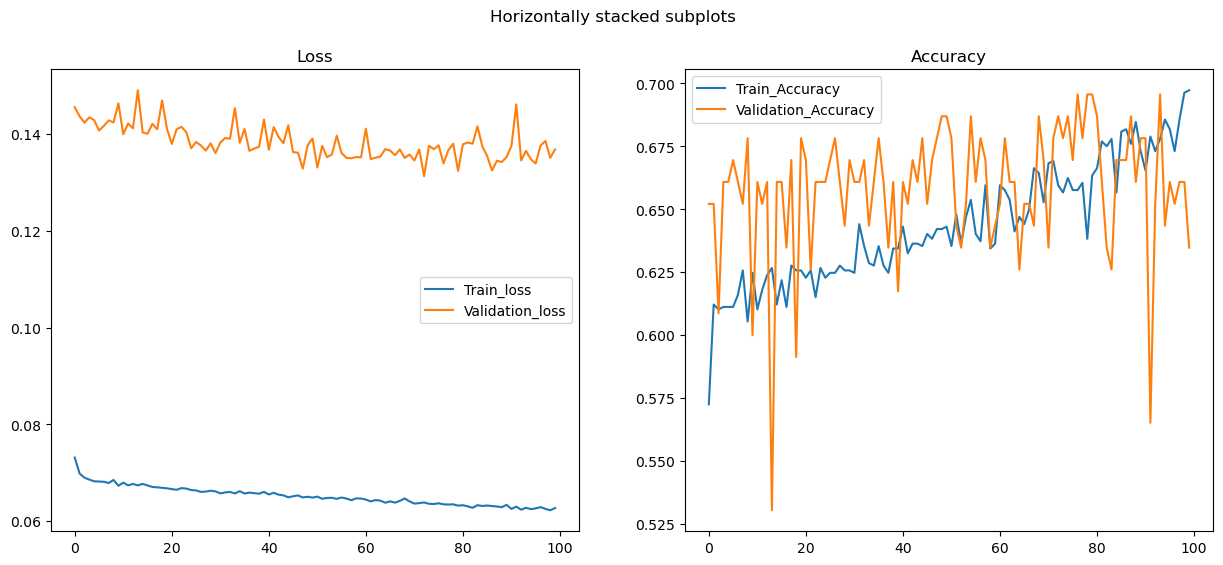

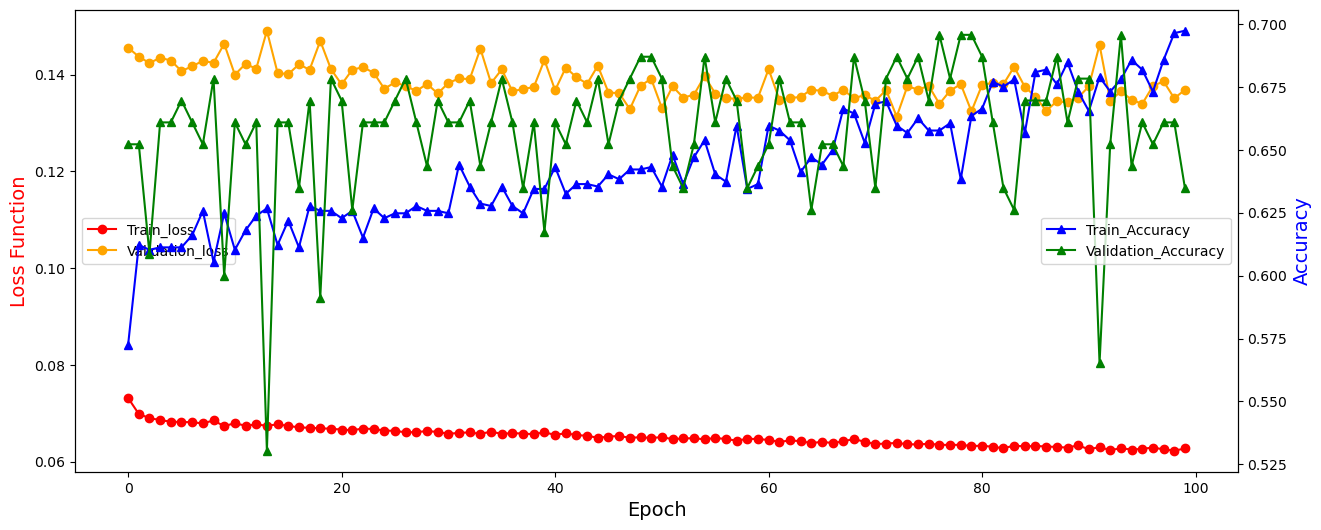

Current time: 35.671 minutes. Time expected till completion: 142.683 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 16.75it/s]


train loss:  0.06263174592180455
Val loss:  0.13483848105306212
train accuracy:  0.6982591876208898
Val accuracy:  0.6608695652173913
Current time: 35.989 minutes. Time expected till completion: 142.175 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.06163785092143533
Val loss:  0.13751805295114933
train accuracy:  0.6963249516441006
Val accuracy:  0.6608695652173913
Current time: 36.305 minutes. Time expected till completion: 141.659 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 15.89it/s]


train loss:  0.06270781603265316
Val loss:  0.13520867098932682
train accuracy:  0.6798839458413927
Val accuracy:  0.6782608695652174
Current time: 36.627 minutes. Time expected till completion: 141.175 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.0622175795888993
Val loss:  0.1377074184625045
train accuracy:  0.7011605415860735
Val accuracy:  0.6695652173913044
Current time: 36.949 minutes. Time expected till completion: 140.689 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


train loss:  0.06195837172825516
Val loss:  0.13574198899061785
train accuracy:  0.7127659574468085
Val accuracy:  0.6608695652173913
Current time: 37.298 minutes. Time expected till completion: 140.312 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.062207372610527494
Val loss:  0.1348901162976804
train accuracy:  0.6972920696324951
Val accuracy:  0.6782608695652174
Current time: 37.616 minutes. Time expected till completion: 139.817 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06219314693021129
Val loss:  0.13150026590927788
train accuracy:  0.688588007736944
Val accuracy:  0.7043478260869566
Current time: 37.932 minutes. Time expected till completion: 139.319 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.06169059221241875
Val loss:  0.13706203647281812
train accuracy:  0.7117988394584139
Val accuracy:  0.591304347826087
Current time: 38.240 minutes. Time expected till completion: 138.796 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


train loss:  0.062226915497844405
Val loss:  0.13342893849248472
train accuracy:  0.7117988394584139
Val accuracy:  0.6695652173913044
Current time: 38.555 minutes. Time expected till completion: 138.304 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06171960047873123
Val loss:  0.1329054718432219
train accuracy:  0.6895551257253385
Val accuracy:  0.6695652173913044
Current time: 38.865 minutes. Time expected till completion: 137.795 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 16.93it/s]


train loss:  0.06157770320571368
Val loss:  0.1330472567807073
train accuracy:  0.7166344294003868
Val accuracy:  0.6608695652173913
Current time: 39.185 minutes. Time expected till completion: 137.323 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.061189885065680086
Val loss:  0.1327705865320952
train accuracy:  0.7292069632495164
Val accuracy:  0.6956521739130435
Current time: 39.505 minutes. Time expected till completion: 136.857 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06170846611203723
Val loss:  0.13247506773990134
train accuracy:  0.7108317214700194
Val accuracy:  0.7130434782608696
Current time: 39.816 minutes. Time expected till completion: 136.363 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 16.06it/s]


train loss:  0.06173443857659685
Val loss:  0.13408001350319904
train accuracy:  0.7021276595744681
Val accuracy:  0.6521739130434783
Current time: 40.137 minutes. Time expected till completion: 135.904 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 16.78it/s]


train loss:  0.06190888413608189
Val loss:  0.13623602338459181
train accuracy:  0.7147001934235977
Val accuracy:  0.6347826086956522
Current time: 40.455 minutes. Time expected till completion: 135.436 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 17.50it/s]


train loss:  0.061543058438273415
Val loss:  0.1373199146726857
train accuracy:  0.7176015473887815
Val accuracy:  0.5739130434782609
Current time: 40.782 minutes. Time expected till completion: 135.003 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06194568862075732
Val loss:  0.13766952493916387
train accuracy:  0.7214700193423598
Val accuracy:  0.6434782608695652
Current time: 41.113 minutes. Time expected till completion: 134.584 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06168347199373596
Val loss:  0.1347199118655661
train accuracy:  0.7079303675048356
Val accuracy:  0.6956521739130435
Current time: 41.479 minutes. Time expected till completion: 134.280 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.0619779745660852
Val loss:  0.13612463785254436
train accuracy:  0.7117988394584139
Val accuracy:  0.6434782608695652
Current time: 41.805 minutes. Time expected till completion: 133.845 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06132785027677363
Val loss:  0.13503319180530052
train accuracy:  0.7176015473887815
Val accuracy:  0.6
Current time: 42.119 minutes. Time expected till completion: 133.378 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.06126425938403353
Val loss:  0.13212288358937138
train accuracy:  0.718568665377176
Val accuracy:  0.6695652173913044
Current time: 42.445 minutes. Time expected till completion: 132.948 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.06105660919525176
Val loss:  0.14214927113574485
train accuracy:  0.7195357833655706
Val accuracy:  0.5826086956521739
Current time: 42.764 minutes. Time expected till completion: 132.497 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 16.78it/s]


train loss:  0.06134403270725125
Val loss:  0.13335125860960587
train accuracy:  0.7340425531914894
Val accuracy:  0.6782608695652174
Current time: 43.085 minutes. Time expected till completion: 132.058 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.060737636149275465
Val loss:  0.13411304121432097
train accuracy:  0.730174081237911
Val accuracy:  0.6869565217391305
Current time: 43.401 minutes. Time expected till completion: 131.602 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 17.16it/s]


train loss:  0.06138602959809958
Val loss:  0.1348265186600063
train accuracy:  0.7253384912959381
Val accuracy:  0.6782608695652174
Current time: 43.712 minutes. Time expected till completion: 131.137 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06116624404198888
Val loss:  0.13422654089720354
train accuracy:  0.7166344294003868
Val accuracy:  0.6608695652173913
Current time: 44.018 minutes. Time expected till completion: 130.656 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06175553579625585
Val loss:  0.13322468374086463
train accuracy:  0.718568665377176
Val accuracy:  0.6608695652173913
Current time: 44.341 minutes. Time expected till completion: 130.231 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


train loss:  0.061264261113375254
Val loss:  0.13920872729757558
train accuracy:  0.7088974854932302
Val accuracy:  0.6434782608695652
Current time: 44.679 minutes. Time expected till completion: 129.848 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06046726406197022
Val loss:  0.13787036564039148
train accuracy:  0.7282398452611218
Val accuracy:  0.6347826086956522
Current time: 44.993 minutes. Time expected till completion: 129.398 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06070619671672179
Val loss:  0.13151606787805972
train accuracy:  0.7243713733075435
Val accuracy:  0.6869565217391305
Current time: 45.322 minutes. Time expected till completion: 128.993 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06149287899412085
Val loss:  0.13792990446090697
train accuracy:  0.7263056092843327
Val accuracy:  0.6260869565217392
Current time: 45.654 minutes. Time expected till completion: 128.599 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06089110421719358
Val loss:  0.13812142506889674
train accuracy:  0.7388781431334622
Val accuracy:  0.6695652173913044
Current time: 45.964 minutes. Time expected till completion: 128.141 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06069280181217009
Val loss:  0.13495789248010387
train accuracy:  0.7243713733075435
Val accuracy:  0.5652173913043478
Current time: 46.278 minutes. Time expected till completion: 127.701 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.05991236061376575
Val loss:  0.13814109511997388
train accuracy:  0.7398452611218569
Val accuracy:  0.6347826086956522
Current time: 46.590 minutes. Time expected till completion: 127.255 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.0602890600088256
Val loss:  0.13724545033081717
train accuracy:  0.7408123791102514
Val accuracy:  0.6695652173913044
Current time: 46.901 minutes. Time expected till completion: 126.807 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.060296363941244276
Val loss:  0.13733639302461043
train accuracy:  0.7562862669245648
Val accuracy:  0.6347826086956522
Current time: 47.215 minutes. Time expected till completion: 126.368 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.060175877359895685
Val loss:  0.13431136297143023
train accuracy:  0.7408123791102514
Val accuracy:  0.6608695652173913
Current time: 47.536 minutes. Time expected till completion: 125.954 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 16.52it/s]


train loss:  0.060608802093066835
Val loss:  0.13879481502201246
train accuracy:  0.7359767891682786
Val accuracy:  0.6347826086956522
Current time: 47.856 minutes. Time expected till completion: 125.536 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 16.50it/s]


train loss:  0.060613019957533196
Val loss:  0.1337695686713509
train accuracy:  0.7398452611218569
Val accuracy:  0.6608695652173913
Current time: 48.176 minutes. Time expected till completion: 125.120 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.060758262987985374
Val loss:  0.13543420252592667
train accuracy:  0.7350096711798839
Val accuracy:  0.7217391304347827
Current time: 48.490 minutes. Time expected till completion: 124.688 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.05993106384803064
Val loss:  0.13669854298881862
train accuracy:  0.7620889748549323
Val accuracy:  0.6260869565217392
Current time: 48.802 minutes. Time expected till completion: 124.255 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


train loss:  0.059845615574654114
Val loss:  0.13869399143301922
train accuracy:  0.7591876208897486
Val accuracy:  0.5565217391304348
Current time: 49.137 minutes. Time expected till completion: 123.881 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


train loss:  0.059799487747583445
Val loss:  0.13024366886719413
train accuracy:  0.7514506769825918
Val accuracy:  0.6782608695652174
Current time: 49.479 minutes. Time expected till completion: 123.524 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


train loss:  0.060256606317350435
Val loss:  0.13686349443767382
train accuracy:  0.7446808510638298
Val accuracy:  0.6695652173913044
Current time: 49.796 minutes. Time expected till completion: 123.106 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 16.65it/s]


train loss:  0.060388688077317905
Val loss:  0.13657148195349653
train accuracy:  0.7456479690522244
Val accuracy:  0.6347826086956522
Current time: 50.113 minutes. Time expected till completion: 122.689 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06026456630437471
Val loss:  0.14088638969089673
train accuracy:  0.7359767891682786
Val accuracy:  0.6086956521739131
Current time: 50.432 minutes. Time expected till completion: 122.281 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


train loss:  0.059935930042709556
Val loss:  0.135628516777702
train accuracy:  0.7572533849129593
Val accuracy:  0.6521739130434783
Current time: 50.755 minutes. Time expected till completion: 121.881 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.059720968715918595
Val loss:  0.13820427448853204
train accuracy:  0.7543520309477756
Val accuracy:  0.6608695652173913
Current time: 51.066 minutes. Time expected till completion: 121.454 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 17.34it/s]


train loss:  0.05962735293451084
Val loss:  0.1352306796156842
train accuracy:  0.7591876208897486
Val accuracy:  0.6695652173913044
Current time: 51.382 minutes. Time expected till completion: 121.040 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 15.81it/s]


train loss:  0.059447798899571254
Val loss:  0.13693098037139229
train accuracy:  0.7640232108317214
Val accuracy:  0.6956521739130435
Current time: 51.702 minutes. Time expected till completion: 120.637 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 16.34it/s]


train loss:  0.0595590561570697
Val loss:  0.13834245256755662
train accuracy:  0.7620889748549323
Val accuracy:  0.6086956521739131
Current time: 52.011 minutes. Time expected till completion: 120.210 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 17.92it/s]


train loss:  0.059627566969371625
Val loss:  0.13451812111813088
train accuracy:  0.7746615087040619
Val accuracy:  0.6608695652173913
Current time: 52.322 minutes. Time expected till completion: 119.790 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 15.14it/s]


train loss:  0.059410419581706564
Val loss:  0.13437400175177533
train accuracy:  0.7872340425531915
Val accuracy:  0.6869565217391305
Current time: 52.631 minutes. Time expected till completion: 119.366 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


train loss:  0.059287851910526566
Val loss:  0.13752062631689985
train accuracy:  0.7649903288201161
Val accuracy:  0.6521739130434783
Current time: 52.935 minutes. Time expected till completion: 118.932 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


train loss:  0.0597357807583689
Val loss:  0.13382224259169206
train accuracy:  0.7620889748549323
Val accuracy:  0.6695652173913044
Current time: 53.239 minutes. Time expected till completion: 118.500 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


train loss:  0.059544524498557676
Val loss:  0.14091708038164222
train accuracy:  0.7688588007736944
Val accuracy:  0.5739130434782609
Current time: 53.557 minutes. Time expected till completion: 118.100 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 16.63it/s]


train loss:  0.058891701744419
Val loss:  0.13648664795834084
train accuracy:  0.7804642166344294
Val accuracy:  0.6434782608695652
Current time: 53.872 minutes. Time expected till completion: 117.695 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.05913735358350743
Val loss:  0.13615769044212672
train accuracy:  0.7794970986460348
Val accuracy:  0.6695652173913044
Current time: 54.196 minutes. Time expected till completion: 117.311 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 16.87it/s]


train loss:  0.05936505744950684
Val loss:  0.13376450538635254
train accuracy:  0.7746615087040619
Val accuracy:  0.6869565217391305
Current time: 54.517 minutes. Time expected till completion: 116.920 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 17.44it/s]


train loss:  0.05852766608822968
Val loss:  0.13501801853594572
train accuracy:  0.776595744680851
Val accuracy:  0.6521739130434783
Current time: 54.833 minutes. Time expected till completion: 116.521 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 16.48it/s]


train loss:  0.05899755671130389
Val loss:  0.1352967127509739
train accuracy:  0.7727272727272727
Val accuracy:  0.6608695652173913
Current time: 55.154 minutes. Time expected till completion: 116.132 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 17.18it/s]


train loss:  0.05836340433393733
Val loss:  0.14031393683474996
train accuracy:  0.7862669245647969
Val accuracy:  0.5826086956521739
Current time: 55.471 minutes. Time expected till completion: 115.736 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.05927728517143131
Val loss:  0.14854383727778558
train accuracy:  0.7640232108317214
Val accuracy:  0.5478260869565217
Current time: 55.798 minutes. Time expected till completion: 115.361 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


train loss:  0.05937506849346124
Val loss:  0.13999015196509984
train accuracy:  0.7843326885880078
Val accuracy:  0.6260869565217392
Current time: 56.123 minutes. Time expected till completion: 114.983 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 16.25it/s]


train loss:  0.058379816132772364
Val loss:  0.13826056926146799
train accuracy:  0.7833655705996132
Val accuracy:  0.6347826086956522
Current time: 56.444 minutes. Time expected till completion: 114.599 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.05809924761607983
Val loss:  0.14074317787004553
train accuracy:  0.793036750483559
Val accuracy:  0.6608695652173913
Current time: 56.755 minutes. Time expected till completion: 114.194 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.05844048184398526
Val loss:  0.13599579178768656
train accuracy:  0.7998065764023211
Val accuracy:  0.6434782608695652
Current time: 57.076 minutes. Time expected till completion: 113.810 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.05868873616943507
Val loss:  0.14013936001321545
train accuracy:  0.7882011605415861
Val accuracy:  0.5826086956521739
Current time: 57.390 minutes. Time expected till completion: 113.414 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.05809167972846926
Val loss:  0.13492856388506683
train accuracy:  0.8027079303675049
Val accuracy:  0.6173913043478261
Current time: 57.696 minutes. Time expected till completion: 113.001 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.05894777063474895
Val loss:  0.14309322989505271
train accuracy:  0.781431334622824
Val accuracy:  0.5826086956521739
Current time: 58.007 minutes. Time expected till completion: 112.602 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.05896729951439789
Val loss:  0.1342251570328422
train accuracy:  0.7785299806576402
Val accuracy:  0.6173913043478261
Current time: 58.332 minutes. Time expected till completion: 112.229 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


train loss:  0.05755979796903968
Val loss:  0.14020599126815797
train accuracy:  0.793036750483559
Val accuracy:  0.6434782608695652
Current time: 58.642 minutes. Time expected till completion: 111.829 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.05815714914748009
Val loss:  0.13773751725321232
train accuracy:  0.8027079303675049
Val accuracy:  0.6260869565217392
Current time: 58.957 minutes. Time expected till completion: 111.438 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.05801550620298552
Val loss:  0.14449883854907491
train accuracy:  0.8104448742746615
Val accuracy:  0.5739130434782609
Current time: 59.278 minutes. Time expected till completion: 111.060 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 15.66it/s]


train loss:  0.057753297473291366
Val loss:  0.14072313775186954
train accuracy:  0.804642166344294
Val accuracy:  0.6173913043478261
Current time: 59.605 minutes. Time expected till completion: 110.695 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 17.30it/s]


train loss:  0.05763536778132736
Val loss:  0.13455983970476235
train accuracy:  0.8152804642166345
Val accuracy:  0.6695652173913044
Current time: 59.918 minutes. Time expected till completion: 110.304 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 17.60it/s]


train loss:  0.05836077100764852
Val loss:  0.14022626203039418
train accuracy:  0.7843326885880078
Val accuracy:  0.6173913043478261
Current time: 60.236 minutes. Time expected till completion: 109.922 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 15.41it/s]


train loss:  0.05825057418249562
Val loss:  0.14030940066213193
train accuracy:  0.7920696324951644
Val accuracy:  0.6086956521739131
Current time: 60.564 minutes. Time expected till completion: 109.560 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


train loss:  0.05862837234364257
Val loss:  0.13365758294644564
train accuracy:  0.7882011605415861
Val accuracy:  0.6521739130434783
Current time: 60.892 minutes. Time expected till completion: 109.197 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 15.78it/s]


train loss:  0.05755740040967266
Val loss:  0.13767985468325408
train accuracy:  0.8065764023210832
Val accuracy:  0.6260869565217392
Current time: 61.208 minutes. Time expected till completion: 108.815 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 15.28it/s]


train loss:  0.05765339121136029
Val loss:  0.14122256092403246
train accuracy:  0.8133462282398453
Val accuracy:  0.6608695652173913
Current time: 61.540 minutes. Time expected till completion: 108.460 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.057845531510661144
Val loss:  0.1352214833964472
train accuracy:  0.8133462282398453
Val accuracy:  0.6695652173913044
Current time: 61.843 minutes. Time expected till completion: 108.056 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 16.83it/s]


train loss:  0.05773223835679502
Val loss:  0.1392131427060003
train accuracy:  0.7969052224371374
Val accuracy:  0.6521739130434783
Current time: 62.153 minutes. Time expected till completion: 107.664 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 16.93it/s]


train loss:  0.05641012334731377
Val loss:  0.13602388371591984
train accuracy:  0.8365570599613152
Val accuracy:  0.6608695652173913
Current time: 62.477 minutes. Time expected till completion: 107.297 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


train loss:  0.0572092432233305
Val loss:  0.13899276515711909
train accuracy:  0.816247582205029
Val accuracy:  0.6521739130434783
Current time: 62.790 minutes. Time expected till completion: 106.913 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:01<00:00, 14.60it/s]


train loss:  0.05659360696545422
Val loss:  0.13859843741292538
train accuracy:  0.8346228239845261
Val accuracy:  0.6521739130434783
Current time: 63.097 minutes. Time expected till completion: 106.519 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


train loss:  0.05750920878618783
Val loss:  0.13347732865292092
train accuracy:  0.8085106382978723
Val accuracy:  0.6869565217391305
Current time: 63.424 minutes. Time expected till completion: 106.159 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.056950701332184515
Val loss:  0.13861867759538735
train accuracy:  0.8259187620889749
Val accuracy:  0.6434782608695652
Current time: 63.754 minutes. Time expected till completion: 105.805 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.057591716948053595
Val loss:  0.14045454004536503
train accuracy:  0.8133462282398453
Val accuracy:  0.6173913043478261
Current time: 64.081 minutes. Time expected till completion: 105.446 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 16.54it/s]


train loss:  0.05743244255765033
Val loss:  0.13613352671913478
train accuracy:  0.8133462282398453
Val accuracy:  0.6869565217391305
Current time: 64.409 minutes. Time expected till completion: 105.088 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 16.68it/s]


train loss:  0.05745835224710535
Val loss:  0.13589729796285216
train accuracy:  0.8065764023210832
Val accuracy:  0.6434782608695652
Current time: 64.730 minutes. Time expected till completion: 104.720 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.056602633264585894
Val loss:  0.1386192772699439
train accuracy:  0.8278529980657641
Val accuracy:  0.6173913043478261
Current time: 65.049 minutes. Time expected till completion: 104.350 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 16.48it/s]


train loss:  0.056843222801643827
Val loss:  0.13842298621716706
train accuracy:  0.8152804642166345
Val accuracy:  0.6695652173913044
Current time: 65.366 minutes. Time expected till completion: 103.977 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 15.60it/s]


train loss:  0.056474246934949776
Val loss:  0.1328731225884479
train accuracy:  0.8326885880077369
Val accuracy:  0.6956521739130435
Current time: 65.682 minutes. Time expected till completion: 103.602 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.05665340483534498
Val loss:  0.144003427028656
train accuracy:  0.8191489361702128
Val accuracy:  0.6173913043478261
Current time: 65.999 minutes. Time expected till completion: 103.229 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.05709830894922149
Val loss:  0.1340694873229317
train accuracy:  0.8249516441005803
Val accuracy:  0.6434782608695652
Current time: 66.314 minutes. Time expected till completion: 102.855 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.056624264274390566
Val loss:  0.13678595345953237
train accuracy:  0.8307543520309478
Val accuracy:  0.6260869565217392
Current time: 66.623 minutes. Time expected till completion: 102.471 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


train loss:  0.05614351799686366
Val loss:  0.13700420130854069
train accuracy:  0.839458413926499
Val accuracy:  0.6608695652173913
Current time: 66.931 minutes. Time expected till completion: 102.087 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:01<00:00, 14.58it/s]


train loss:  0.056387569848988454
Val loss:  0.13691744648891946
train accuracy:  0.8404255319148937
Val accuracy:  0.6782608695652174
Current time: 67.255 minutes. Time expected till completion: 101.728 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 16.91it/s]


train loss:  0.05652391812556948
Val loss:  0.13705742359161377
train accuracy:  0.8346228239845261
Val accuracy:  0.6782608695652174
Saving model checkpoint


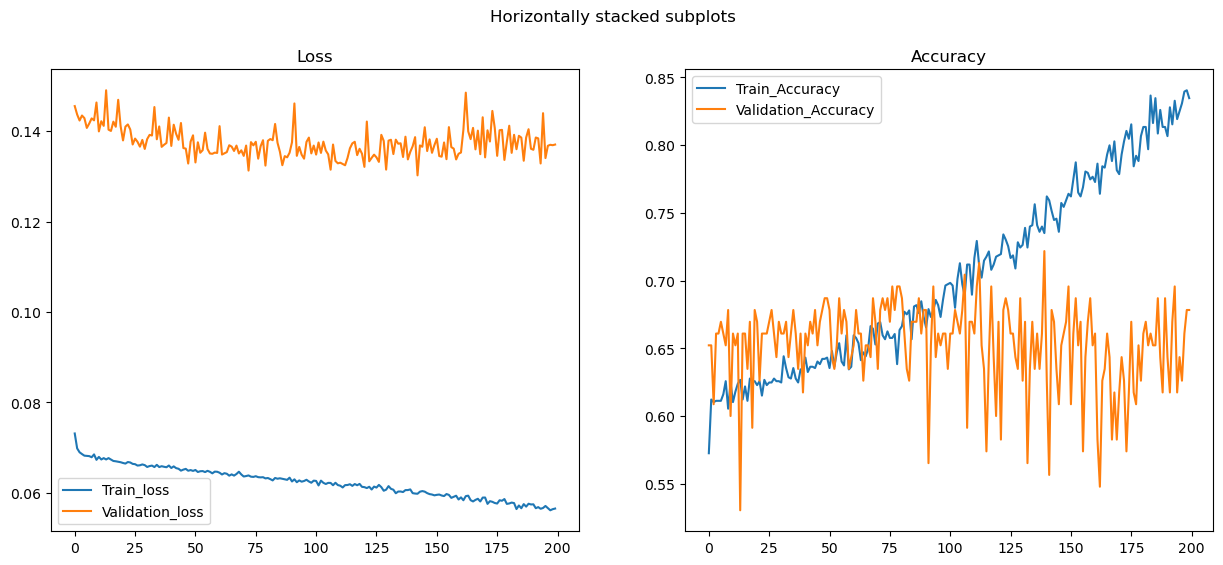

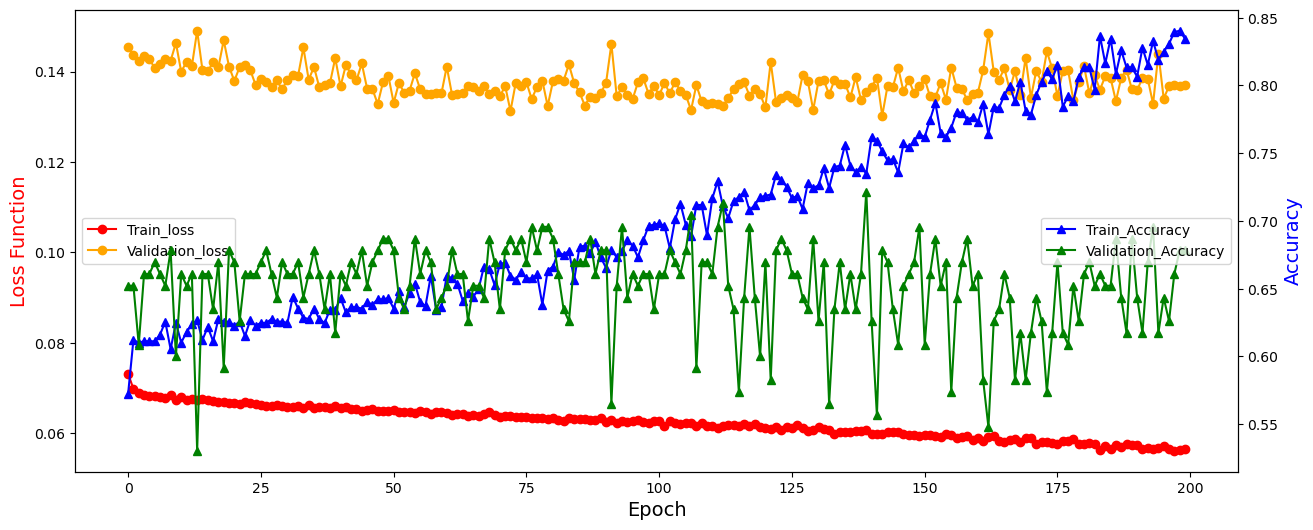

Current time: 67.588 minutes. Time expected till completion: 101.383 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.05704601763295482
Val loss:  0.13893636413242505
train accuracy:  0.8259187620889749
Val accuracy:  0.6695652173913044
Current time: 67.925 minutes. Time expected till completion: 101.043 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 15.32it/s]


train loss:  0.055655985782409316
Val loss:  0.1395340551500735
train accuracy:  0.8452611218568665
Val accuracy:  0.6521739130434783
Current time: 68.249 minutes. Time expected till completion: 100.684 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.056389267889627864
Val loss:  0.14436704490495764
train accuracy:  0.8355899419729207
Val accuracy:  0.6173913043478261
Current time: 68.560 minutes. Time expected till completion: 100.307 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.05762651914323552
Val loss:  0.13929106930027838
train accuracy:  0.8075435203094777
Val accuracy:  0.6260869565217392
Current time: 68.889 minutes. Time expected till completion: 99.956 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 16.75it/s]


train loss:  0.05645524193055394
Val loss:  0.13842770016711692
train accuracy:  0.8268858800773694
Val accuracy:  0.6347826086956522
Current time: 69.201 minutes. Time expected till completion: 99.582 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


train loss:  0.05604008105322286
Val loss:  0.14065163135528563
train accuracy:  0.8500967117988395
Val accuracy:  0.6260869565217392
Current time: 69.524 minutes. Time expected till completion: 99.223 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.056680644561520395
Val loss:  0.13899730443954467
train accuracy:  0.8249516441005803
Val accuracy:  0.6434782608695652
Current time: 69.843 minutes. Time expected till completion: 98.860 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 16.65it/s]


train loss:  0.05587441357468729
Val loss:  0.1403596712195355
train accuracy:  0.8375241779497099
Val accuracy:  0.6260869565217392
Current time: 70.164 minutes. Time expected till completion: 98.499 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 17.10it/s]


train loss:  0.05678816073406596
Val loss:  0.13725172488585763
train accuracy:  0.8230174081237911
Val accuracy:  0.6434782608695652
Current time: 70.482 minutes. Time expected till completion: 98.135 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.05562310857514579
Val loss:  0.14049478406491486
train accuracy:  0.8404255319148937
Val accuracy:  0.6347826086956522
Current time: 70.792 minutes. Time expected till completion: 97.760 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 16.85it/s]


train loss:  0.056234439117996096
Val loss:  0.1368854413861814
train accuracy:  0.8326885880077369
Val accuracy:  0.6695652173913044
Current time: 71.098 minutes. Time expected till completion: 97.381 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.05718345089853386
Val loss:  0.13859692915626196
train accuracy:  0.8133462282398453
Val accuracy:  0.6695652173913044
Current time: 71.411 minutes. Time expected till completion: 97.011 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.05556616769307356
Val loss:  0.13077700345412543
train accuracy:  0.8462282398452611
Val accuracy:  0.7043478260869566
Current time: 71.727 minutes. Time expected till completion: 96.646 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:01<00:00, 12.08it/s]


train loss:  0.05517167423633819
Val loss:  0.13568004732546599
train accuracy:  0.8578336557059961
Val accuracy:  0.6695652173913044
Current time: 72.059 minutes. Time expected till completion: 96.303 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:01<00:00, 14.75it/s]


train loss:  0.05597139667265651
Val loss:  0.1406984956368156
train accuracy:  0.8346228239845261
Val accuracy:  0.6608695652173913
Current time: 72.381 minutes. Time expected till completion: 95.946 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


train loss:  0.055728810956445836
Val loss:  0.13981077930201655
train accuracy:  0.851063829787234
Val accuracy:  0.6434782608695652
Current time: 72.704 minutes. Time expected till completion: 95.593 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


train loss:  0.05599342312526887
Val loss:  0.14861224578774493
train accuracy:  0.8423597678916828
Val accuracy:  0.5652173913043478
Current time: 73.034 minutes. Time expected till completion: 95.247 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 15.89it/s]


train loss:  0.056442752048171466
Val loss:  0.1376894437748453
train accuracy:  0.8268858800773694
Val accuracy:  0.6608695652173913
Current time: 73.358 minutes. Time expected till completion: 94.894 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.05559474327808653
Val loss:  0.1387104982915132
train accuracy:  0.844294003868472
Val accuracy:  0.6521739130434783
Current time: 73.685 minutes. Time expected till completion: 94.546 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 16.68it/s]


train loss:  0.054719891781041426
Val loss:  0.13416322832522184
train accuracy:  0.8597678916827853
Val accuracy:  0.7130434782608696
Current time: 74.008 minutes. Time expected till completion: 94.192 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 16.70it/s]


train loss:  0.055894303483243604
Val loss:  0.13266859624696814
train accuracy:  0.8336557059961315
Val accuracy:  0.7043478260869566
Current time: 74.333 minutes. Time expected till completion: 93.841 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 16.34it/s]


train loss:  0.05494800953616026
Val loss:  0.13278866332510245
train accuracy:  0.8558994197292069
Val accuracy:  0.6869565217391305
Current time: 74.667 minutes. Time expected till completion: 93.502 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 15.82it/s]


train loss:  0.05490365549489654
Val loss:  0.14081797651622607
train accuracy:  0.8578336557059961
Val accuracy:  0.6260869565217392
Current time: 74.979 minutes. Time expected till completion: 93.135 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.05460157563884669
Val loss:  0.13630318797152977
train accuracy:  0.8713733075435203
Val accuracy:  0.6434782608695652
Current time: 75.309 minutes. Time expected till completion: 92.792 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 16.27it/s]


train loss:  0.054912695801696186
Val loss:  0.1356566258098768
train accuracy:  0.8684719535783365
Val accuracy:  0.7043478260869566
Current time: 75.630 minutes. Time expected till completion: 92.437 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 16.11it/s]


train loss:  0.05600989452874868
Val loss:  0.13730602212574172
train accuracy:  0.8433268858800773
Val accuracy:  0.6782608695652174
Current time: 75.938 minutes. Time expected till completion: 92.067 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


train loss:  0.05538157366461173
Val loss:  0.13767632764318716
train accuracy:  0.8549323017408124
Val accuracy:  0.6434782608695652
Current time: 76.258 minutes. Time expected till completion: 91.711 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.054644014722374006
Val loss:  0.13903156000634898
train accuracy:  0.8646034816247582
Val accuracy:  0.6434782608695652
Current time: 76.574 minutes. Time expected till completion: 91.351 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 16.95it/s]


train loss:  0.054715329662282416
Val loss:  0.14764932497687963
train accuracy:  0.8665377176015474
Val accuracy:  0.5739130434782609
Current time: 76.887 minutes. Time expected till completion: 90.989 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.05527042760378618
Val loss:  0.1368521996166395
train accuracy:  0.8520309477756286
Val accuracy:  0.6695652173913044
Current time: 77.199 minutes. Time expected till completion: 90.625 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.054546418976276476
Val loss:  0.14421212776847508
train accuracy:  0.8694390715667312
Val accuracy:  0.6
Current time: 77.516 minutes. Time expected till completion: 90.267 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


train loss:  0.05496549295041732
Val loss:  0.13393293360005254
train accuracy:  0.8471953578336557
Val accuracy:  0.6782608695652174
Current time: 77.833 minutes. Time expected till completion: 89.911 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.05394668516845261
Val loss:  0.1427345887474392
train accuracy:  0.874274661508704
Val accuracy:  0.6173913043478261
Current time: 78.158 minutes. Time expected till completion: 89.564 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


train loss:  0.05501168257263228
Val loss:  0.13641847268394802
train accuracy:  0.8568665377176016
Val accuracy:  0.6869565217391305
Current time: 78.469 minutes. Time expected till completion: 89.199 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 15.71it/s]


train loss:  0.055014272838312145
Val loss:  0.13457504510879517
train accuracy:  0.8646034816247582
Val accuracy:  0.6956521739130435
Current time: 78.783 minutes. Time expected till completion: 88.841 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.054218486671982695
Val loss:  0.13709346833436387
train accuracy:  0.8771760154738878
Val accuracy:  0.6695652173913044
Current time: 79.129 minutes. Time expected till completion: 88.517 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 17.44it/s]


train loss:  0.05380076498542579
Val loss:  0.13838153870209405
train accuracy:  0.8800773694390716
Val accuracy:  0.6347826086956522
Current time: 79.442 minutes. Time expected till completion: 88.157 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.054350936551158614
Val loss:  0.129530203860739
train accuracy:  0.8597678916827853
Val accuracy:  0.7304347826086957
Current time: 79.762 minutes. Time expected till completion: 87.805 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 16.91it/s]


train loss:  0.05394227511647592
Val loss:  0.13700183474499247
train accuracy:  0.8752417794970987
Val accuracy:  0.6869565217391305
Current time: 80.087 minutes. Time expected till completion: 87.459 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.05436981784997641
Val loss:  0.14008333734844042
train accuracy:  0.8723404255319149
Val accuracy:  0.6608695652173913
Current time: 80.404 minutes. Time expected till completion: 87.105 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.0544132303223158
Val loss:  0.14087523740270863
train accuracy:  0.8684719535783365
Val accuracy:  0.6521739130434783
Current time: 80.713 minutes. Time expected till completion: 86.741 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.054083924459534874
Val loss:  0.1371296737505042
train accuracy:  0.8704061895551257
Val accuracy:  0.6695652173913044
Current time: 81.036 minutes. Time expected till completion: 86.394 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.054097901056998014
Val loss:  0.1412311087483945
train accuracy:  0.8684719535783365
Val accuracy:  0.6173913043478261
Current time: 81.357 minutes. Time expected till completion: 86.044 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.05506810799558112
Val loss:  0.14057198659233425
train accuracy:  0.8617021276595744
Val accuracy:  0.6434782608695652
Current time: 81.677 minutes. Time expected till completion: 85.694 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.05407002066735834
Val loss:  0.1396285336950551
train accuracy:  0.8733075435203095
Val accuracy:  0.6608695652173913
Current time: 81.987 minutes. Time expected till completion: 85.334 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.05371132377729656
Val loss:  0.13889577181442925
train accuracy:  0.8800773694390716
Val accuracy:  0.6347826086956522
Current time: 82.297 minutes. Time expected till completion: 84.973 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.05388420105441626
Val loss:  0.14040638156559157
train accuracy:  0.8771760154738878
Val accuracy:  0.6260869565217392
Current time: 82.617 minutes. Time expected till completion: 84.624 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.053324058277233424
Val loss:  0.1344890656678573
train accuracy:  0.8936170212765957
Val accuracy:  0.7043478260869566
Current time: 82.934 minutes. Time expected till completion: 84.272 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 16.89it/s]


train loss:  0.053710076172531686
Val loss:  0.1429737106613491
train accuracy:  0.8713733075435203
Val accuracy:  0.6260869565217392
Current time: 83.247 minutes. Time expected till completion: 83.915 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.05384508276815802
Val loss:  0.13391997088556704
train accuracy:  0.8810444874274661
Val accuracy:  0.6608695652173913
Current time: 83.561 minutes. Time expected till completion: 83.561 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.05280456171736726
Val loss:  0.13841396466545436
train accuracy:  0.8965183752417795
Val accuracy:  0.6608695652173913
Current time: 83.872 minutes. Time expected till completion: 83.204 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.053379710050339396
Val loss:  0.13287762351658033
train accuracy:  0.8800773694390716
Val accuracy:  0.7304347826086957
Current time: 84.188 minutes. Time expected till completion: 82.851 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


train loss:  0.05357405716261504
Val loss:  0.14110453180644822
train accuracy:  0.8887814313346228
Val accuracy:  0.6347826086956522
Current time: 84.508 minutes. Time expected till completion: 82.504 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.053767270806679646
Val loss:  0.13905031836551168
train accuracy:  0.8771760154738878
Val accuracy:  0.6521739130434783
Current time: 84.829 minutes. Time expected till completion: 82.157 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 15.61it/s]


train loss:  0.05336687729713765
Val loss:  0.1408931141314299
train accuracy:  0.8829787234042553
Val accuracy:  0.6260869565217392
Current time: 85.148 minutes. Time expected till completion: 81.809 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.05281225319526643
Val loss:  0.1511800537938657
train accuracy:  0.9013539651837524
Val accuracy:  0.5739130434782609
Current time: 85.478 minutes. Time expected till completion: 81.471 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.05247426384652837
Val loss:  0.14129633281541906
train accuracy:  0.902321083172147
Val accuracy:  0.6347826086956522
Current time: 85.782 minutes. Time expected till completion: 81.109 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 17.58it/s]


train loss:  0.053050055725200954
Val loss:  0.13737055996189948
train accuracy:  0.8945841392649904
Val accuracy:  0.6782608695652174
Current time: 86.103 minutes. Time expected till completion: 80.763 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 16.30it/s]


train loss:  0.05318942475826182
Val loss:  0.15224688053131102
train accuracy:  0.8926499032882012
Val accuracy:  0.5304347826086957
Current time: 86.420 minutes. Time expected till completion: 80.414 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 16.63it/s]


train loss:  0.05445052138610781
Val loss:  0.13995119799738345
train accuracy:  0.8704061895551257
Val accuracy:  0.6347826086956522
Current time: 86.729 minutes. Time expected till completion: 80.057 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.05354319838536777
Val loss:  0.1420025830683501
train accuracy:  0.8858800773694391
Val accuracy:  0.6521739130434783
Current time: 87.049 minutes. Time expected till completion: 79.712 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 15.74it/s]


train loss:  0.05329283697231595
Val loss:  0.13833970816239066
train accuracy:  0.8849129593810445
Val accuracy:  0.6347826086956522
Current time: 87.369 minutes. Time expected till completion: 79.366 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.053344256066261454
Val loss:  0.13906256530595862
train accuracy:  0.8887814313346228
Val accuracy:  0.6260869565217392
Current time: 87.685 minutes. Time expected till completion: 79.016 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.053379934749474146
Val loss:  0.13235637882481452
train accuracy:  0.8868471953578336
Val accuracy:  0.6956521739130435
Current time: 88.012 minutes. Time expected till completion: 78.677 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 16.52it/s]


train loss:  0.05261443212368963
Val loss:  0.13751718946125197
train accuracy:  0.90715667311412
Val accuracy:  0.6434782608695652
Current time: 88.336 minutes. Time expected till completion: 78.336 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


train loss:  0.05323692383803067
Val loss:  0.13219385250754978
train accuracy:  0.8829787234042553
Val accuracy:  0.7304347826086957
Current time: 88.654 minutes. Time expected till completion: 77.989 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 17.14it/s]


train loss:  0.0530338261989837
Val loss:  0.1345385509988536
train accuracy:  0.8858800773694391
Val accuracy:  0.6782608695652174
Current time: 88.980 minutes. Time expected till completion: 77.649 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.05289562954432268
Val loss:  0.13759001648944358
train accuracy:  0.8945841392649904
Val accuracy:  0.6782608695652174
Current time: 89.298 minutes. Time expected till completion: 77.303 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  0.052712620976353985
Val loss:  0.13663910575534988
train accuracy:  0.8955512572533849
Val accuracy:  0.6782608695652174
Current time: 89.619 minutes. Time expected till completion: 76.959 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:01<00:00, 14.82it/s]


train loss:  0.05249024757564183
Val loss:  0.13458635133245717
train accuracy:  0.8994197292069632
Val accuracy:  0.6869565217391305
Current time: 89.945 minutes. Time expected till completion: 76.620 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.05301144171498961
Val loss:  0.14133612228476483
train accuracy:  0.8897485493230174
Val accuracy:  0.6260869565217392
Current time: 90.261 minutes. Time expected till completion: 76.272 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:01<00:00, 14.82it/s]


train loss:  0.052964730696244675
Val loss:  0.13831674430681312
train accuracy:  0.8868471953578336
Val accuracy:  0.6347826086956522
Current time: 90.577 minutes. Time expected till completion: 75.925 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 16.93it/s]


train loss:  0.05312296108304878
Val loss:  0.13825431232867033
train accuracy:  0.8907156673114119
Val accuracy:  0.6695652173913044
Current time: 90.893 minutes. Time expected till completion: 75.578 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 16.97it/s]


train loss:  0.052393405246089
Val loss:  0.13523306172827015
train accuracy:  0.9090909090909091
Val accuracy:  0.7130434782608696
Current time: 91.231 minutes. Time expected till completion: 75.249 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:01<00:00, 14.81it/s]


train loss:  0.05260344083120099
Val loss:  0.1368727093157561
train accuracy:  0.9013539651837524
Val accuracy:  0.6347826086956522
Current time: 91.550 minutes. Time expected till completion: 74.905 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:00<00:00, 17.48it/s]


train loss:  0.05221816038485883
Val loss:  0.13676738479863043
train accuracy:  0.9013539651837524
Val accuracy:  0.6608695652173913
Current time: 91.872 minutes. Time expected till completion: 74.563 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 17.36it/s]


train loss:  0.05256815251806027
Val loss:  0.13514423422191454
train accuracy:  0.90715667311412
Val accuracy:  0.6608695652173913
Current time: 92.191 minutes. Time expected till completion: 74.218 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 16.63it/s]


train loss:  0.05144296059064293
Val loss:  0.13861596636150195
train accuracy:  0.9177949709864603
Val accuracy:  0.6434782608695652
Current time: 92.536 minutes. Time expected till completion: 73.896 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 16.32it/s]


train loss:  0.051459488428307686
Val loss:  0.1390880356664243
train accuracy:  0.9226305609284333
Val accuracy:  0.6521739130434783
Current time: 92.861 minutes. Time expected till completion: 73.556 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.05214386855610565
Val loss:  0.13740346431732178
train accuracy:  0.9100580270793037
Val accuracy:  0.6608695652173913
Current time: 93.176 minutes. Time expected till completion: 73.210 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 16.52it/s]


train loss:  0.0519245281901996
Val loss:  0.13637433829514878
train accuracy:  0.9148936170212766
Val accuracy:  0.6869565217391305
Current time: 93.506 minutes. Time expected till completion: 72.875 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.05198455946357845
Val loss:  0.14053042505098426
train accuracy:  0.9081237911025145
Val accuracy:  0.6521739130434783
Current time: 93.833 minutes. Time expected till completion: 72.537 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.051529888085285976
Val loss:  0.1423409430877022
train accuracy:  0.9226305609284333
Val accuracy:  0.6086956521739131
Current time: 94.145 minutes. Time expected till completion: 72.189 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.05213871039089889
Val loss:  0.13608039462048074
train accuracy:  0.9081237911025145
Val accuracy:  0.6956521739130435
Current time: 94.467 minutes. Time expected till completion: 71.849 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.052073559516633734
Val loss:  0.14275682335314543
train accuracy:  0.9110251450676983
Val accuracy:  0.6260869565217392
Current time: 94.781 minutes. Time expected till completion: 71.502 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 16.85it/s]


train loss:  0.05203224058538618
Val loss:  0.14254769605139028
train accuracy:  0.9119922630560928
Val accuracy:  0.6173913043478261
Current time: 95.090 minutes. Time expected till completion: 71.152 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.05195246097889352
Val loss:  0.1374504110087519
train accuracy:  0.9168278529980658
Val accuracy:  0.6869565217391305
Current time: 95.409 minutes. Time expected till completion: 70.809 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 16.72it/s]


train loss:  0.05172516045302902
Val loss:  0.13258982223013174
train accuracy:  0.9235976789168279
Val accuracy:  0.7217391304347827
Current time: 95.727 minutes. Time expected till completion: 70.466 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.05158604891895095
Val loss:  0.1440530362336532
train accuracy:  0.9197292069632496
Val accuracy:  0.6260869565217392
Current time: 96.048 minutes. Time expected till completion: 70.125 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.05228971305160965
Val loss:  0.1395608715389086
train accuracy:  0.902321083172147
Val accuracy:  0.6173913043478261
Current time: 96.371 minutes. Time expected till completion: 69.786 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 16.91it/s]


train loss:  0.051877638645743955
Val loss:  0.14008542610251384
train accuracy:  0.913926499032882
Val accuracy:  0.6608695652173913
Current time: 96.682 minutes. Time expected till completion: 69.439 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


train loss:  0.05118936081227758
Val loss:  0.13394170170244962
train accuracy:  0.9245647969052224
Val accuracy:  0.6608695652173913
Current time: 96.996 minutes. Time expected till completion: 69.093 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 17.96it/s]


train loss:  0.051918223010271616
Val loss:  0.1395495461381
train accuracy:  0.9081237911025145
Val accuracy:  0.6782608695652174
Current time: 97.316 minutes. Time expected till completion: 68.752 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:01<00:00, 14.71it/s]


train loss:  0.051517574711048855
Val loss:  0.1480426259662794
train accuracy:  0.9177949709864603
Val accuracy:  0.591304347826087
Current time: 97.643 minutes. Time expected till completion: 68.417 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


train loss:  0.05168650551506353
Val loss:  0.14396883663923843
train accuracy:  0.9177949709864603
Val accuracy:  0.6260869565217392
Current time: 97.964 minutes. Time expected till completion: 68.077 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


train loss:  0.05095945428372352
Val loss:  0.14372134260509326
train accuracy:  0.9313346228239845
Val accuracy:  0.6086956521739131
Current time: 98.286 minutes. Time expected till completion: 67.738 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.05127139951550984
Val loss:  0.13705507724181465
train accuracy:  0.9235976789168279
Val accuracy:  0.6347826086956522
Current time: 98.606 minutes. Time expected till completion: 67.397 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.051192950349250664
Val loss:  0.13421067880547566
train accuracy:  0.9284332688588007
Val accuracy:  0.6956521739130435
Current time: 98.928 minutes. Time expected till completion: 67.058 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


train loss:  0.05069445105309182
Val loss:  0.1368828244831251
train accuracy:  0.937137330754352
Val accuracy:  0.6695652173913044
Current time: 99.244 minutes. Time expected till completion: 66.716 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:00<00:00, 16.93it/s]


train loss:  0.050388577885969
Val loss:  0.13877720780994582
train accuracy:  0.9448742746615088
Val accuracy:  0.6521739130434783
Saving model checkpoint


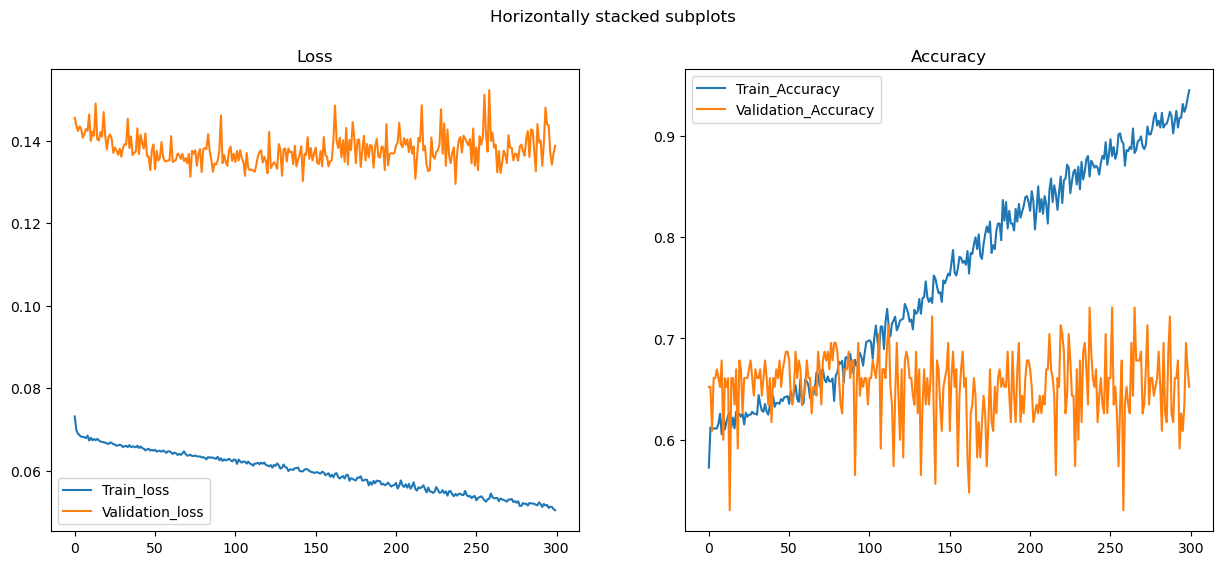

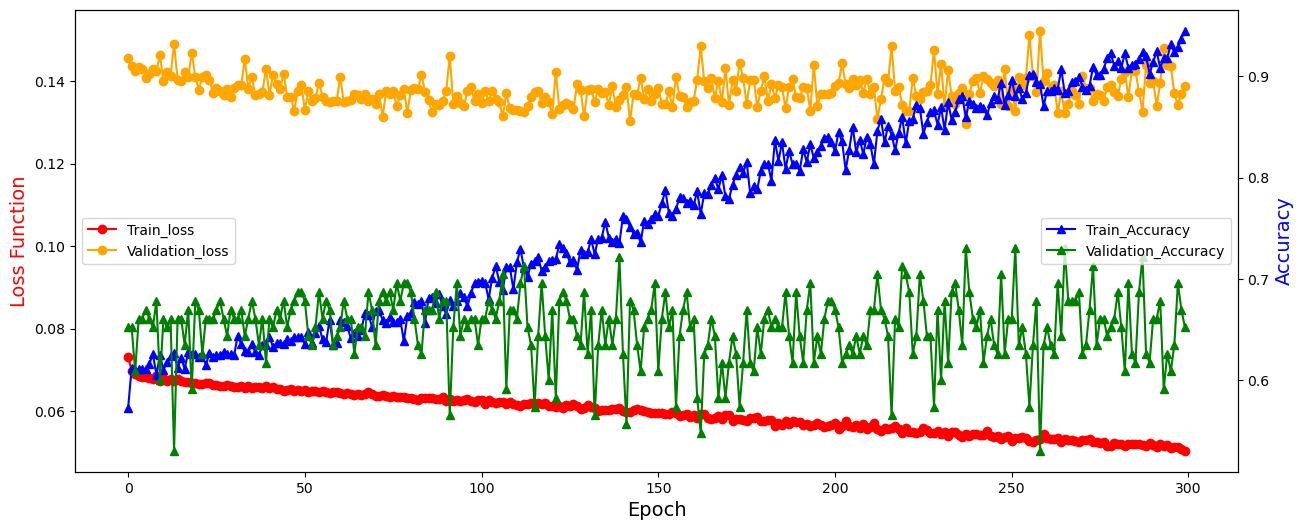

Current time: 99.586 minutes. Time expected till completion: 66.390 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.05182301928964759
Val loss:  0.13920367541520492
train accuracy:  0.9100580270793037
Val accuracy:  0.6260869565217392
Current time: 99.903 minutes. Time expected till completion: 66.049 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.05112041507053191
Val loss:  0.1411201352658479
train accuracy:  0.9303675048355899
Val accuracy:  0.6521739130434783
Current time: 100.222 minutes. Time expected till completion: 65.708 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.052397424582125374
Val loss:  0.13786270722098973
train accuracy:  0.9003868471953579
Val accuracy:  0.6608695652173913
Current time: 100.533 minutes. Time expected till completion: 65.363 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 15.66it/s]


train loss:  0.05198602427366393
Val loss:  0.1403679433076278
train accuracy:  0.9090909090909091
Val accuracy:  0.6260869565217392
Current time: 100.847 minutes. Time expected till completion: 65.020 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 15.42it/s]


train loss:  0.05279999072132074
Val loss:  0.13598654840303503
train accuracy:  0.8897485493230174
Val accuracy:  0.6695652173913044
Current time: 101.151 minutes. Time expected till completion: 64.670 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.051356469754785354
Val loss:  0.14028049396431963
train accuracy:  0.9245647969052224
Val accuracy:  0.6260869565217392
Current time: 101.467 minutes. Time expected till completion: 64.329 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 17.56it/s]


train loss:  0.05145331617711361
Val loss:  0.15012685371481854
train accuracy:  0.9284332688588007
Val accuracy:  0.5304347826086957
Current time: 101.778 minutes. Time expected till completion: 63.984 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


train loss:  0.05119176033156522
Val loss:  0.1429063221682673
train accuracy:  0.9284332688588007
Val accuracy:  0.6173913043478261
Current time: 102.094 minutes. Time expected till completion: 63.643 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.05081695202932598
Val loss:  0.1381854720737623
train accuracy:  0.9313346228239845
Val accuracy:  0.6695652173913044
Current time: 102.418 minutes. Time expected till completion: 63.307 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 16.85it/s]


train loss:  0.05073614571265141
Val loss:  0.13987250068913334
train accuracy:  0.9390715667311412
Val accuracy:  0.6173913043478261
Current time: 102.748 minutes. Time expected till completion: 62.975 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.05202934710845726
Val loss:  0.14382269382476806
train accuracy:  0.913926499032882
Val accuracy:  0.6173913043478261
Current time: 103.062 minutes. Time expected till completion: 62.633 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 16.78it/s]


train loss:  0.0507101064378565
Val loss:  0.14652152424273285
train accuracy:  0.9352030947775629
Val accuracy:  0.5652173913043478
Current time: 103.384 minutes. Time expected till completion: 62.295 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 16.52it/s]


train loss:  0.05093537181673474
Val loss:  0.13998991458312324
train accuracy:  0.9264990328820116
Val accuracy:  0.6260869565217392
Current time: 103.696 minutes. Time expected till completion: 61.953 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 16.36it/s]


train loss:  0.05126296764877364
Val loss:  0.14235256547513214
train accuracy:  0.9168278529980658
Val accuracy:  0.6260869565217392
Current time: 104.017 minutes. Time expected till completion: 61.615 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 15.15it/s]


train loss:  0.050246722290087024
Val loss:  0.14458177556162294
train accuracy:  0.9458413926499033
Val accuracy:  0.591304347826087
Current time: 104.326 minutes. Time expected till completion: 61.271 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


train loss:  0.050583924154248415
Val loss:  0.13924474560696146
train accuracy:  0.9313346228239845
Val accuracy:  0.6173913043478261
Current time: 104.644 minutes. Time expected till completion: 60.932 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 16.87it/s]


train loss:  0.051741921405958256
Val loss:  0.14090706783792248
train accuracy:  0.9148936170212766
Val accuracy:  0.6260869565217392
Current time: 104.961 minutes. Time expected till completion: 60.593 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.0506500679012424
Val loss:  0.1395097053569296
train accuracy:  0.9352030947775629
Val accuracy:  0.6521739130434783
Current time: 105.291 minutes. Time expected till completion: 60.261 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 16.41it/s]


train loss:  0.05094448832985972
Val loss:  0.1359273780947146
train accuracy:  0.9274661508704062
Val accuracy:  0.6695652173913044
Current time: 105.610 minutes. Time expected till completion: 59.923 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 17.30it/s]


train loss:  0.049841701465603
Val loss:  0.1398075803466465
train accuracy:  0.9506769825918762
Val accuracy:  0.6347826086956522
Current time: 105.932 minutes. Time expected till completion: 59.587 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.05042711061711929
Val loss:  0.13387787601222162
train accuracy:  0.9400386847195358
Val accuracy:  0.7043478260869566
Current time: 106.242 minutes. Time expected till completion: 59.244 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 16.97it/s]


train loss:  0.05106102123251275
Val loss:  0.14681278363518094
train accuracy:  0.9303675048355899
Val accuracy:  0.5565217391304348
Current time: 106.569 minutes. Time expected till completion: 58.911 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 16.65it/s]


train loss:  0.0515029384273625
Val loss:  0.1415643785310828
train accuracy:  0.9168278529980658
Val accuracy:  0.6434782608695652
Current time: 106.895 minutes. Time expected till completion: 58.577 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.05027367638665426
Val loss:  0.13616405725479125
train accuracy:  0.9410058027079303
Val accuracy:  0.6869565217391305
Current time: 107.222 minutes. Time expected till completion: 58.244 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 16.70it/s]


train loss:  0.050662503712873626
Val loss:  0.1389965508295142
train accuracy:  0.9342359767891683
Val accuracy:  0.6695652173913044
Current time: 107.550 minutes. Time expected till completion: 57.912 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.05130635591032888
Val loss:  0.13592828149380892
train accuracy:  0.9226305609284333
Val accuracy:  0.6695652173913044
Current time: 107.865 minutes. Time expected till completion: 57.572 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:00<00:00, 16.89it/s]


train loss:  0.05094982196560681
Val loss:  0.13140257752459983
train accuracy:  0.9294003868471954
Val accuracy:  0.6956521739130435
Current time: 108.195 minutes. Time expected till completion: 57.241 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.050028457286510064
Val loss:  0.13628331733786542
train accuracy:  0.9477756286266924
Val accuracy:  0.6608695652173913
Current time: 108.523 minutes. Time expected till completion: 56.909 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 15.66it/s]


train loss:  0.050551639188880844
Val loss:  0.1374691569286844
train accuracy:  0.9400386847195358
Val accuracy:  0.6608695652173913
Current time: 108.848 minutes. Time expected till completion: 56.575 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 16.48it/s]


train loss:  0.04999354988970655
Val loss:  0.14288663708645363
train accuracy:  0.9506769825918762
Val accuracy:  0.6173913043478261
Current time: 109.156 minutes. Time expected till completion: 56.232 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.051089585634449236
Val loss:  0.13994267194167428
train accuracy:  0.9264990328820116
Val accuracy:  0.6347826086956522
Current time: 109.471 minutes. Time expected till completion: 55.893 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.05044881985081464
Val loss:  0.1371088110882303
train accuracy:  0.9400386847195358
Val accuracy:  0.6521739130434783
Current time: 109.780 minutes. Time expected till completion: 55.551 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 17.24it/s]


train loss:  0.05078504336871769
Val loss:  0.1364275802736697
train accuracy:  0.9323017408123792
Val accuracy:  0.6869565217391305
Current time: 110.102 minutes. Time expected till completion: 55.216 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 16.34it/s]


train loss:  0.05066766804606587
Val loss:  0.13401132407395736
train accuracy:  0.9332688588007737
Val accuracy:  0.7043478260869566
Current time: 110.413 minutes. Time expected till completion: 54.876 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 16.93it/s]


train loss:  0.05072592207495433
Val loss:  0.14086666107177734
train accuracy:  0.9332688588007737
Val accuracy:  0.6434782608695652
Current time: 110.726 minutes. Time expected till completion: 54.537 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 17.26it/s]


train loss:  0.050579177745306285
Val loss:  0.14850690779478654
train accuracy:  0.9342359767891683
Val accuracy:  0.5652173913043478
Current time: 111.040 minutes. Time expected till completion: 54.198 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.05053182508313679
Val loss:  0.1505269688108693
train accuracy:  0.941972920696325
Val accuracy:  0.5565217391304348
Current time: 111.373 minutes. Time expected till completion: 53.869 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


train loss:  0.05045313196440499
Val loss:  0.14365327306415723
train accuracy:  0.941972920696325
Val accuracy:  0.6086956521739131
Current time: 111.692 minutes. Time expected till completion: 53.533 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.050325381225497394
Val loss:  0.13727683502694835
train accuracy:  0.9439071566731141
Val accuracy:  0.6608695652173913
Current time: 111.999 minutes. Time expected till completion: 53.191 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 16.65it/s]


train loss:  0.05064609283635418
Val loss:  0.13518029658690742
train accuracy:  0.937137330754352
Val accuracy:  0.6695652173913044
Current time: 112.338 minutes. Time expected till completion: 52.865 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 16.70it/s]


train loss:  0.05006285049237412
Val loss:  0.141146255057791
train accuracy:  0.9448742746615088
Val accuracy:  0.6347826086956522
Current time: 112.669 minutes. Time expected till completion: 52.535 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 17.38it/s]


train loss:  0.050580944267877986
Val loss:  0.13936480491057687
train accuracy:  0.9332688588007737
Val accuracy:  0.6434782608695652
Current time: 112.987 minutes. Time expected till completion: 52.199 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


train loss:  0.05057592687108761
Val loss:  0.147060401543327
train accuracy:  0.9352030947775629
Val accuracy:  0.591304347826087
Current time: 113.326 minutes. Time expected till completion: 51.872 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.05063925882372681
Val loss:  0.14042336474294248
train accuracy:  0.9323017408123792
Val accuracy:  0.6
Current time: 113.638 minutes. Time expected till completion: 51.533 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 15.81it/s]


train loss:  0.050254405813014255
Val loss:  0.13873328125995138
train accuracy:  0.9468085106382979
Val accuracy:  0.6695652173913044
Current time: 113.972 minutes. Time expected till completion: 51.205 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


train loss:  0.05014757111639764
Val loss:  0.139164996665457
train accuracy:  0.9439071566731141
Val accuracy:  0.6260869565217392
Current time: 114.283 minutes. Time expected till completion: 50.866 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 15.99it/s]


train loss:  0.049771469554772
Val loss:  0.1377485197523366
train accuracy:  0.9516441005802708
Val accuracy:  0.6608695652173913
Current time: 114.594 minutes. Time expected till completion: 50.527 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


train loss:  0.050611703204463024
Val loss:  0.1411531598671623
train accuracy:  0.9390715667311412
Val accuracy:  0.6173913043478261
Current time: 114.905 minutes. Time expected till completion: 50.188 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.050840902086383366
Val loss:  0.13904599262320477
train accuracy:  0.9274661508704062
Val accuracy:  0.6434782608695652
Current time: 115.215 minutes. Time expected till completion: 49.850 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 16.65it/s]


train loss:  0.050742692308684154
Val loss:  0.140604189167852
train accuracy:  0.9323017408123792
Val accuracy:  0.6347826086956522
Current time: 115.531 minutes. Time expected till completion: 49.513 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.04987043776410691
Val loss:  0.13574789296025816
train accuracy:  0.9477756286266924
Val accuracy:  0.6608695652173913
Current time: 115.844 minutes. Time expected till completion: 49.176 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


train loss:  0.04975876062243773
Val loss:  0.14245529071144436
train accuracy:  0.9545454545454546
Val accuracy:  0.6347826086956522
Current time: 116.165 minutes. Time expected till completion: 48.842 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


train loss:  0.04981426321099759
Val loss:  0.14316041987875233
train accuracy:  0.9555125725338491
Val accuracy:  0.591304347826087
Current time: 116.487 minutes. Time expected till completion: 48.509 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


train loss:  0.0506592054546917
Val loss:  0.14458945367647255
train accuracy:  0.9313346228239845
Val accuracy:  0.6173913043478261
Current time: 116.809 minutes. Time expected till completion: 48.175 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 16.43it/s]


train loss:  0.05056162025757869
Val loss:  0.14416371894919355
train accuracy:  0.9342359767891683
Val accuracy:  0.5826086956521739
Current time: 117.129 minutes. Time expected till completion: 47.842 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


train loss:  0.05026713739972511
Val loss:  0.1347825050354004
train accuracy:  0.9390715667311412
Val accuracy:  0.6869565217391305
Current time: 117.452 minutes. Time expected till completion: 47.509 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 16.08it/s]


train loss:  0.050367604256598586
Val loss:  0.13069425303003063
train accuracy:  0.937137330754352
Val accuracy:  0.7130434782608696
Current time: 117.774 minutes. Time expected till completion: 47.176 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.0499726959884282
Val loss:  0.13591633516809215
train accuracy:  0.9545454545454546
Val accuracy:  0.6782608695652174
Current time: 118.097 minutes. Time expected till completion: 46.843 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.049695845902311964
Val loss:  0.13591743759486985
train accuracy:  0.9497098646034816
Val accuracy:  0.6869565217391305
Current time: 118.421 minutes. Time expected till completion: 46.511 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 16.16it/s]


train loss:  0.04978199911302017
Val loss:  0.14299590483955715
train accuracy:  0.9487427466150871
Val accuracy:  0.6173913043478261
Current time: 118.734 minutes. Time expected till completion: 46.174 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.04966641314025082
Val loss:  0.14040344124254972
train accuracy:  0.9506769825918762
Val accuracy:  0.6260869565217392
Current time: 119.054 minutes. Time expected till completion: 45.841 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.05003488138750397
Val loss:  0.13583089631536732
train accuracy:  0.9477756286266924
Val accuracy:  0.6869565217391305
Current time: 119.378 minutes. Time expected till completion: 45.509 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.049459634424408816
Val loss:  0.13696165084838868
train accuracy:  0.9574468085106383
Val accuracy:  0.6347826086956522
Current time: 119.697 minutes. Time expected till completion: 45.175 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.04960748697387873
Val loss:  0.1370526365611864
train accuracy:  0.9593810444874274
Val accuracy:  0.6608695652173913
Current time: 120.020 minutes. Time expected till completion: 44.843 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.04984005034776905
Val loss:  0.134526076524154
train accuracy:  0.9516441005802708
Val accuracy:  0.7130434782608696
Current time: 120.336 minutes. Time expected till completion: 44.508 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.05094129423569434
Val loss:  0.14103117507437002
train accuracy:  0.9284332688588007
Val accuracy:  0.6173913043478261
Current time: 120.651 minutes. Time expected till completion: 44.173 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.05055410505724599
Val loss:  0.143985901189887
train accuracy:  0.9342359767891683
Val accuracy:  0.6
Current time: 120.965 minutes. Time expected till completion: 43.837 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 17.42it/s]


train loss:  0.05066458024877183
Val loss:  0.13836903623912644
train accuracy:  0.9332688588007737
Val accuracy:  0.6521739130434783
Current time: 121.272 minutes. Time expected till completion: 43.500 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 16.43it/s]


train loss:  0.049678457371270864
Val loss:  0.13643043870511262
train accuracy:  0.9516441005802708
Val accuracy:  0.6608695652173913
Current time: 121.589 minutes. Time expected till completion: 43.166 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 16.41it/s]


train loss:  0.04975137275930069
Val loss:  0.14262409417525582
train accuracy:  0.9516441005802708
Val accuracy:  0.6347826086956522
Current time: 121.913 minutes. Time expected till completion: 42.834 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


train loss:  0.04935632983305468
Val loss:  0.1351416976555534
train accuracy:  0.9584139264990329
Val accuracy:  0.6434782608695652
Current time: 122.230 minutes. Time expected till completion: 42.500 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:01<00:00, 14.45it/s]


train loss:  0.05000498233726915
Val loss:  0.14361403610395349
train accuracy:  0.9487427466150871
Val accuracy:  0.6086956521739131
Current time: 122.555 minutes. Time expected till completion: 42.170 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.05025128469706965
Val loss:  0.1392210628675378
train accuracy:  0.941972920696325
Val accuracy:  0.6608695652173913
Current time: 122.877 minutes. Time expected till completion: 41.837 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.04961408095387472
Val loss:  0.1385994138924972
train accuracy:  0.9487427466150871
Val accuracy:  0.6782608695652174
Current time: 123.199 minutes. Time expected till completion: 41.506 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 16.76it/s]


train loss:  0.049334960645587116
Val loss:  0.13900280309760052
train accuracy:  0.9593810444874274
Val accuracy:  0.6608695652173913
Current time: 123.528 minutes. Time expected till completion: 41.176 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:00<00:00, 16.81it/s]


train loss:  0.04997299845029584
Val loss:  0.13929519135019053
train accuracy:  0.9497098646034816
Val accuracy:  0.6782608695652174
Current time: 123.853 minutes. Time expected till completion: 40.845 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.050183465448523396
Val loss:  0.13790977519491446
train accuracy:  0.9448742746615088
Val accuracy:  0.6782608695652174
Current time: 124.175 minutes. Time expected till completion: 40.513 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


train loss:  0.05040059271817973
Val loss:  0.15676188209782477
train accuracy:  0.9429400386847195
Val accuracy:  0.5304347826086957
Current time: 124.490 minutes. Time expected till completion: 40.179 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 16.74it/s]


train loss:  0.05033453826286345
Val loss:  0.14751796929732613
train accuracy:  0.9400386847195358
Val accuracy:  0.5739130434782609
Current time: 124.807 minutes. Time expected till completion: 39.846 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.050486959387301474
Val loss:  0.1388411055440488
train accuracy:  0.9352030947775629
Val accuracy:  0.6521739130434783
Current time: 125.134 minutes. Time expected till completion: 39.516 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:00<00:00, 16.41it/s]


train loss:  0.05012274215023107
Val loss:  0.13861110158588574
train accuracy:  0.9448742746615088
Val accuracy:  0.6521739130434783
Current time: 125.449 minutes. Time expected till completion: 39.182 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 16.20it/s]


train loss:  0.05017433579240131
Val loss:  0.13803560992945796
train accuracy:  0.9429400386847195
Val accuracy:  0.6782608695652174
Current time: 125.760 minutes. Time expected till completion: 38.847 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


train loss:  0.04925265988943886
Val loss:  0.13413245470627494
train accuracy:  0.9564796905222437
Val accuracy:  0.6869565217391305
Current time: 126.081 minutes. Time expected till completion: 38.516 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:00<00:00, 16.72it/s]


train loss:  0.0491896027291997
Val loss:  0.1383764085562333
train accuracy:  0.965183752417795
Val accuracy:  0.6434782608695652
Current time: 126.403 minutes. Time expected till completion: 38.184 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:00<00:00, 16.32it/s]


train loss:  0.0496474043313032
Val loss:  0.14229634326437246
train accuracy:  0.9545454545454546
Val accuracy:  0.6260869565217392
Current time: 126.759 minutes. Time expected till completion: 37.863 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 17.40it/s]


train loss:  0.050131351735651836
Val loss:  0.14382893365362417
train accuracy:  0.9448742746615088
Val accuracy:  0.6260869565217392
Current time: 127.074 minutes. Time expected till completion: 37.530 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:00<00:00, 16.16it/s]


train loss:  0.0499655538071055
Val loss:  0.1377715307733287
train accuracy:  0.9439071566731141
Val accuracy:  0.6782608695652174
Current time: 127.398 minutes. Time expected till completion: 37.199 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.049673813915806074
Val loss:  0.13979999967243362
train accuracy:  0.9516441005802708
Val accuracy:  0.6434782608695652
Current time: 127.735 minutes. Time expected till completion: 36.872 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 16.76it/s]


train loss:  0.049227845622676944
Val loss:  0.1437579165334287
train accuracy:  0.960348162475822
Val accuracy:  0.6260869565217392
Current time: 128.071 minutes. Time expected till completion: 36.545 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


train loss:  0.050199138241994776
Val loss:  0.13971097935800966
train accuracy:  0.9381044487427466
Val accuracy:  0.6347826086956522
Current time: 128.410 minutes. Time expected till completion: 36.218 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.049323774398641385
Val loss:  0.13680490721826968
train accuracy:  0.9593810444874274
Val accuracy:  0.6521739130434783
Current time: 128.741 minutes. Time expected till completion: 35.889 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


train loss:  0.0494603677805895
Val loss:  0.14032352903614873
train accuracy:  0.9564796905222437
Val accuracy:  0.6521739130434783
Current time: 129.066 minutes. Time expected till completion: 35.559 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 15.61it/s]


train loss:  0.049580871885934234
Val loss:  0.13847248191418854
train accuracy:  0.9545454545454546
Val accuracy:  0.6608695652173913
Current time: 129.388 minutes. Time expected till completion: 35.228 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:01<00:00, 12.99it/s]


train loss:  0.04955454542512359
Val loss:  0.1419462774110877
train accuracy:  0.9545454545454546
Val accuracy:  0.6434782608695652
Current time: 129.717 minutes. Time expected till completion: 34.898 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.04934743392628904
Val loss:  0.13456295417702716
train accuracy:  0.9555125725338491
Val accuracy:  0.6956521739130435
Current time: 130.046 minutes. Time expected till completion: 34.569 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 16.25it/s]


train loss:  0.050120983179118235
Val loss:  0.13495062745135764
train accuracy:  0.9458413926499033
Val accuracy:  0.6695652173913044
Current time: 130.379 minutes. Time expected till completion: 34.241 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.05013461362001283
Val loss:  0.13561123505882594
train accuracy:  0.9410058027079303
Val accuracy:  0.6608695652173913
Current time: 130.710 minutes. Time expected till completion: 33.912 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:01<00:00, 12.07it/s]


train loss:  0.04968039296581851
Val loss:  0.13530520252559497
train accuracy:  0.9535783365570599
Val accuracy:  0.6869565217391305
Current time: 131.038 minutes. Time expected till completion: 33.583 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.049537860563230236
Val loss:  0.1372821683469026
train accuracy:  0.9545454545454546
Val accuracy:  0.6695652173913044
Current time: 131.365 minutes. Time expected till completion: 33.253 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.04966184963801843
Val loss:  0.1385500721309496
train accuracy:  0.9526112185686654
Val accuracy:  0.6521739130434783
Saving model checkpoint


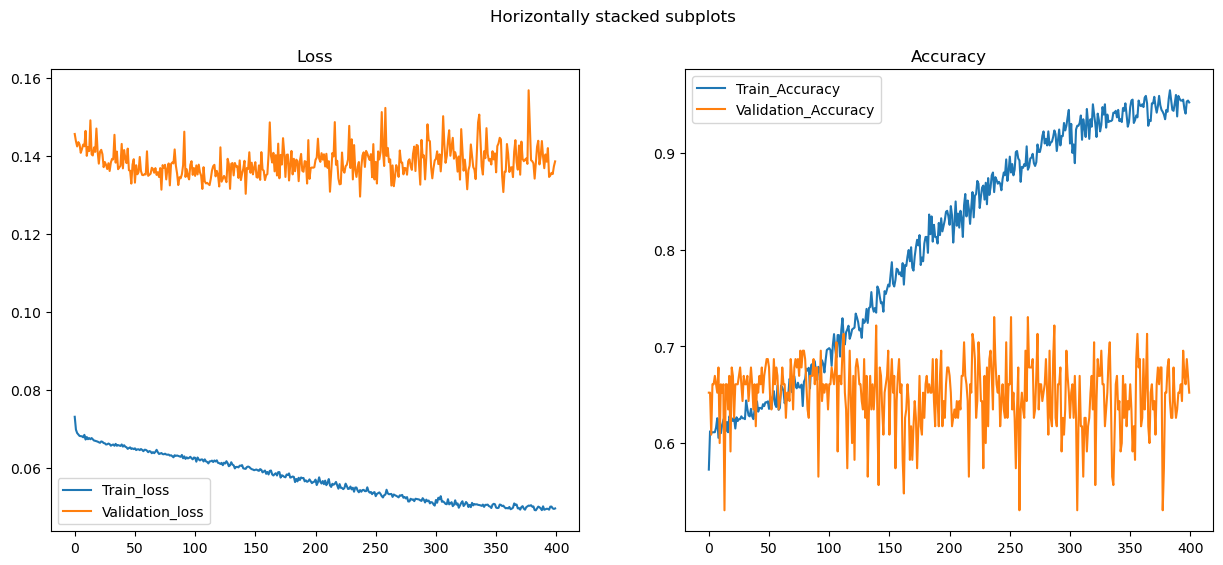

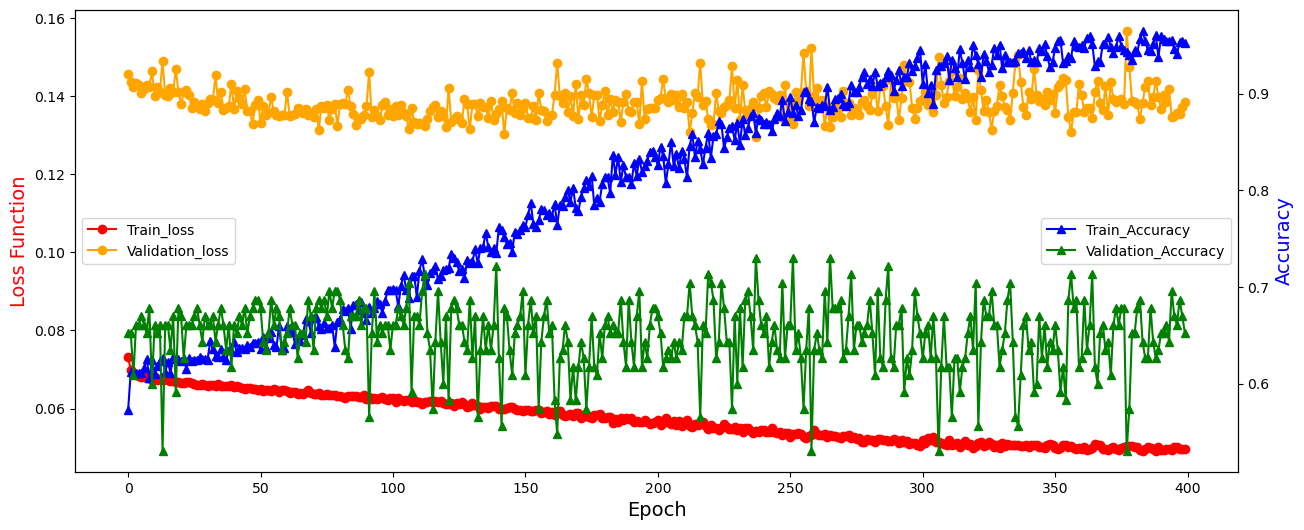

Current time: 131.686 minutes. Time expected till completion: 32.922 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.04967132049326279
Val loss:  0.13887668537056963
train accuracy:  0.9506769825918762
Val accuracy:  0.6260869565217392
Current time: 132.028 minutes. Time expected till completion: 32.595 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 16.83it/s]


train loss:  0.05018625977652677
Val loss:  0.13261591610701187
train accuracy:  0.9448742746615088
Val accuracy:  0.7130434782608696
Current time: 132.350 minutes. Time expected till completion: 32.264 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.04944071069907404
Val loss:  0.13958084116811337
train accuracy:  0.9555125725338491
Val accuracy:  0.6521739130434783
Current time: 132.659 minutes. Time expected till completion: 31.930 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.04988648761171898
Val loss:  0.13635254372721134
train accuracy:  0.9497098646034816
Val accuracy:  0.6869565217391305
Current time: 132.965 minutes. Time expected till completion: 31.596 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.050091655503389225
Val loss:  0.13989337993704754
train accuracy:  0.9458413926499033
Val accuracy:  0.6521739130434783
Current time: 133.280 minutes. Time expected till completion: 31.263 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


train loss:  0.04936586012000964
Val loss:  0.13912683829017308
train accuracy:  0.9574468085106383
Val accuracy:  0.6434782608695652
Current time: 133.594 minutes. Time expected till completion: 30.931 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


train loss:  0.04906129393171757
Val loss:  0.13879018866497536
train accuracy:  0.9632495164410058
Val accuracy:  0.6608695652173913
Current time: 133.915 minutes. Time expected till completion: 30.600 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 16.91it/s]


train loss:  0.04981723202958098
Val loss:  0.14113108386164125
train accuracy:  0.9516441005802708
Val accuracy:  0.6173913043478261
Current time: 134.222 minutes. Time expected till completion: 30.266 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.04979230258866021
Val loss:  0.1409073979958244
train accuracy:  0.9487427466150871
Val accuracy:  0.6608695652173913
Current time: 134.555 minutes. Time expected till completion: 29.938 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.04985992106063223
Val loss:  0.14260130343229874
train accuracy:  0.9458413926499033
Val accuracy:  0.6434782608695652
Current time: 134.892 minutes. Time expected till completion: 29.610 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 16.23it/s]


train loss:  0.04996921908924612
Val loss:  0.1399628571842028
train accuracy:  0.9448742746615088
Val accuracy:  0.6695652173913044
Current time: 135.213 minutes. Time expected till completion: 29.280 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.04947075876092081
Val loss:  0.1392222549604333
train accuracy:  0.9593810444874274
Val accuracy:  0.6521739130434783
Current time: 135.534 minutes. Time expected till completion: 28.949 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 16.63it/s]


train loss:  0.050279789955519155
Val loss:  0.13895860495774642
train accuracy:  0.9390715667311412
Val accuracy:  0.6521739130434783
Current time: 135.846 minutes. Time expected till completion: 28.616 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


train loss:  0.04974650541172729
Val loss:  0.13299166534257972
train accuracy:  0.9477756286266924
Val accuracy:  0.7130434782608696
Current time: 136.158 minutes. Time expected till completion: 28.284 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 15.49it/s]


train loss:  0.04956498834335135
Val loss:  0.13573647219201793
train accuracy:  0.9516441005802708
Val accuracy:  0.6521739130434783
Current time: 136.474 minutes. Time expected till completion: 27.953 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 17.91it/s]


train loss:  0.04977611531602576
Val loss:  0.13371812001518582
train accuracy:  0.9506769825918762
Val accuracy:  0.6956521739130435
Current time: 136.784 minutes. Time expected till completion: 27.620 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.04943606603307005
Val loss:  0.13760083810142848
train accuracy:  0.9584139264990329
Val accuracy:  0.6695652173913044
Current time: 137.102 minutes. Time expected till completion: 27.289 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


train loss:  0.04891664614068701
Val loss:  0.14018232718757961
train accuracy:  0.9661508704061895
Val accuracy:  0.6434782608695652
Current time: 137.428 minutes. Time expected till completion: 26.959 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.04984854798713551
Val loss:  0.13696494517119034
train accuracy:  0.9487427466150871
Val accuracy:  0.6695652173913044
Current time: 137.742 minutes. Time expected till completion: 26.628 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


train loss:  0.04936222112386324
Val loss:  0.13245078428931858
train accuracy:  0.9574468085106383
Val accuracy:  0.6869565217391305
Current time: 138.059 minutes. Time expected till completion: 26.297 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 16.87it/s]


train loss:  0.0490594057787779
Val loss:  0.13228739344555399
train accuracy:  0.9613152804642167
Val accuracy:  0.7304347826086957
Current time: 138.377 minutes. Time expected till completion: 25.966 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:01<00:00, 14.44it/s]


train loss:  0.04923674954205924
Val loss:  0.13336873054504395
train accuracy:  0.9574468085106383
Val accuracy:  0.7130434782608696
Current time: 138.694 minutes. Time expected till completion: 25.635 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.049758955634539546
Val loss:  0.13143078244250753
train accuracy:  0.9448742746615088
Val accuracy:  0.7217391304347827
Current time: 139.001 minutes. Time expected till completion: 25.303 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.04931566493884738
Val loss:  0.13064681498900704
train accuracy:  0.9545454545454546
Val accuracy:  0.7217391304347827
Current time: 139.319 minutes. Time expected till completion: 24.972 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 16.75it/s]


train loss:  0.05008437595468886
Val loss:  0.1412889117779939
train accuracy:  0.9410058027079303
Val accuracy:  0.6173913043478261
Current time: 139.639 minutes. Time expected till completion: 24.642 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.049425633317958455
Val loss:  0.13476482681606128
train accuracy:  0.9545454545454546
Val accuracy:  0.7043478260869566
Current time: 139.964 minutes. Time expected till completion: 24.313 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 16.81it/s]


train loss:  0.04939163249973172
Val loss:  0.14292267198147982
train accuracy:  0.9584139264990329
Val accuracy:  0.6260869565217392
Current time: 140.280 minutes. Time expected till completion: 23.982 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.04893999196574582
Val loss:  0.13599194547404414
train accuracy:  0.9661508704061895
Val accuracy:  0.6956521739130435
Current time: 140.594 minutes. Time expected till completion: 23.651 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 16.72it/s]


train loss:  0.049817417991461097
Val loss:  0.1408698180447454
train accuracy:  0.9487427466150871
Val accuracy:  0.6521739130434783
Current time: 140.914 minutes. Time expected till completion: 23.321 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.049806176520869626
Val loss:  0.13497983372729758
train accuracy:  0.9468085106382979
Val accuracy:  0.6869565217391305
Current time: 141.235 minutes. Time expected till completion: 22.992 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 15.59it/s]


train loss:  0.049091187448058876
Val loss:  0.1324154268140378
train accuracy:  0.960348162475822
Val accuracy:  0.7043478260869566
Current time: 141.549 minutes. Time expected till completion: 22.661 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.0491147077636977
Val loss:  0.14002927749053293
train accuracy:  0.9593810444874274
Val accuracy:  0.6521739130434783
Current time: 141.883 minutes. Time expected till completion: 22.334 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.04910470490529413
Val loss:  0.13719408460285354
train accuracy:  0.9622823984526112
Val accuracy:  0.6695652173913044
Current time: 142.184 minutes. Time expected till completion: 22.001 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.0492454314139641
Val loss:  0.13542347006175828
train accuracy:  0.9584139264990329
Val accuracy:  0.6869565217391305
Current time: 142.487 minutes. Time expected till completion: 21.669 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.04943879902708692
Val loss:  0.14477411301239676
train accuracy:  0.9516441005802708
Val accuracy:  0.6086956521739131
Current time: 142.790 minutes. Time expected till completion: 21.336 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.05006719321531299
Val loss:  0.1360837558041448
train accuracy:  0.9458413926499033
Val accuracy:  0.6695652173913044
Current time: 143.091 minutes. Time expected till completion: 21.004 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.04918434674089605
Val loss:  0.138875993438389
train accuracy:  0.960348162475822
Val accuracy:  0.6608695652173913
Current time: 143.392 minutes. Time expected till completion: 20.672 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.049289782861215235
Val loss:  0.14118373342182325
train accuracy:  0.9584139264990329
Val accuracy:  0.6086956521739131
Current time: 143.694 minutes. Time expected till completion: 20.340 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.04934546593540642
Val loss:  0.1412298358005026
train accuracy:  0.9564796905222437
Val accuracy:  0.6434782608695652
Current time: 143.994 minutes. Time expected till completion: 20.008 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.04921108645673416
Val loss:  0.138948000513989
train accuracy:  0.9584139264990329
Val accuracy:  0.6608695652173913
Current time: 144.298 minutes. Time expected till completion: 19.677 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.04921489873292137
Val loss:  0.14083465596903924
train accuracy:  0.960348162475822
Val accuracy:  0.6347826086956522
Current time: 144.600 minutes. Time expected till completion: 19.346 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


train loss:  0.04921447994400039
Val loss:  0.13782920941062596
train accuracy:  0.960348162475822
Val accuracy:  0.6695652173913044
Current time: 144.900 minutes. Time expected till completion: 19.014 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.049476584336743824
Val loss:  0.13776959232662034
train accuracy:  0.9535783365570599
Val accuracy:  0.6608695652173913
Current time: 145.200 minutes. Time expected till completion: 18.683 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


train loss:  0.04911733970651313
Val loss:  0.14014583307763803
train accuracy:  0.960348162475822
Val accuracy:  0.6434782608695652
Current time: 145.500 minutes. Time expected till completion: 18.351 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


train loss:  0.04887897099009796
Val loss:  0.13724855754686438
train accuracy:  0.9661508704061895
Val accuracy:  0.6434782608695652
Current time: 145.800 minutes. Time expected till completion: 18.020 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.049779311773624824
Val loss:  0.13990516973578412
train accuracy:  0.9497098646034816
Val accuracy:  0.6608695652173913
Current time: 146.103 minutes. Time expected till completion: 17.690 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.048827487622285025
Val loss:  0.1374633586925009
train accuracy:  0.9671179883945842
Val accuracy:  0.6782608695652174
Current time: 146.403 minutes. Time expected till completion: 17.359 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.0489326533312032
Val loss:  0.1415334411289381
train accuracy:  0.9671179883945842
Val accuracy:  0.6608695652173913
Current time: 146.705 minutes. Time expected till completion: 17.028 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


train loss:  0.049101067177331655
Val loss:  0.1378906794216322
train accuracy:  0.9632495164410058
Val accuracy:  0.6782608695652174
Current time: 147.009 minutes. Time expected till completion: 16.698 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.049484244398268325
Val loss:  0.1410244926162388
train accuracy:  0.9555125725338491
Val accuracy:  0.6434782608695652
Current time: 147.309 minutes. Time expected till completion: 16.368 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.049150473086930796
Val loss:  0.13783847456393034
train accuracy:  0.9593810444874274
Val accuracy:  0.6695652173913044
Current time: 147.611 minutes. Time expected till completion: 16.038 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


train loss:  0.04919899144071214
Val loss:  0.14043101020481275
train accuracy:  0.9564796905222437
Val accuracy:  0.6260869565217392
Current time: 147.911 minutes. Time expected till completion: 15.707 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.04887915314742629
Val loss:  0.1424766815227011
train accuracy:  0.9622823984526112
Val accuracy:  0.6173913043478261
Current time: 148.212 minutes. Time expected till completion: 15.377 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.04909033494023336
Val loss:  0.1389928102493286
train accuracy:  0.9574468085106383
Val accuracy:  0.6782608695652174
Current time: 148.513 minutes. Time expected till completion: 15.048 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.04917740279977972
Val loss:  0.13532160468723464
train accuracy:  0.9584139264990329
Val accuracy:  0.6695652173913044
Current time: 148.813 minutes. Time expected till completion: 14.718 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.04958064805147035
Val loss:  0.14067272569822228
train accuracy:  0.9526112185686654
Val accuracy:  0.6434782608695652
Current time: 149.113 minutes. Time expected till completion: 14.388 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.04897024783682316
Val loss:  0.13818960552630216
train accuracy:  0.9632495164410058
Val accuracy:  0.6521739130434783
Current time: 149.413 minutes. Time expected till completion: 14.059 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.04878497642520779
Val loss:  0.13847306500310483
train accuracy:  0.9671179883945842
Val accuracy:  0.6695652173913044
Current time: 149.712 minutes. Time expected till completion: 13.729 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


train loss:  0.04907844848282333
Val loss:  0.14578169014142908
train accuracy:  0.960348162475822
Val accuracy:  0.5826086956521739
Current time: 150.012 minutes. Time expected till completion: 13.400 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


train loss:  0.04855053221925776
Val loss:  0.1462955671807994
train accuracy:  0.9690522243713733
Val accuracy:  0.6
Current time: 150.312 minutes. Time expected till completion: 13.071 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.048739599997116474
Val loss:  0.1413318193477133
train accuracy:  0.9680851063829787
Val accuracy:  0.6434782608695652
Current time: 150.614 minutes. Time expected till completion: 12.742 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


train loss:  0.048679523184405535
Val loss:  0.13631564482398656
train accuracy:  0.9680851063829787
Val accuracy:  0.7043478260869566
Current time: 150.914 minutes. Time expected till completion: 12.413 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.048815985136382585
Val loss:  0.13660474445508874
train accuracy:  0.965183752417795
Val accuracy:  0.6956521739130435
Current time: 151.215 minutes. Time expected till completion: 12.084 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.04903481753697939
Val loss:  0.1430302039436672
train accuracy:  0.9622823984526112
Val accuracy:  0.6173913043478261
Current time: 151.520 minutes. Time expected till completion: 11.756 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.04904088643118307
Val loss:  0.1374153406723686
train accuracy:  0.9613152804642167
Val accuracy:  0.6695652173913044
Current time: 151.819 minutes. Time expected till completion: 11.427 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.0489538376520404
Val loss:  0.1398317067519478
train accuracy:  0.9642166344294004
Val accuracy:  0.6608695652173913
Current time: 152.119 minutes. Time expected till completion: 11.099 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.04915244194248428
Val loss:  0.1337022947228473
train accuracy:  0.9613152804642167
Val accuracy:  0.6956521739130435
Current time: 152.420 minutes. Time expected till completion: 10.771 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.049366785087253416
Val loss:  0.13562830945719842
train accuracy:  0.9545454545454546
Val accuracy:  0.6869565217391305
Current time: 152.723 minutes. Time expected till completion: 10.443 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


train loss:  0.04923026727753866
Val loss:  0.14506770994352258
train accuracy:  0.9574468085106383
Val accuracy:  0.6347826086956522
Current time: 153.024 minutes. Time expected till completion: 10.115 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.04942335934888002
Val loss:  0.1409635393515877
train accuracy:  0.9516441005802708
Val accuracy:  0.6434782608695652
Current time: 153.327 minutes. Time expected till completion: 9.787 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.04871190822101423
Val loss:  0.13682840233263763
train accuracy:  0.9671179883945842
Val accuracy:  0.6869565217391305
Current time: 153.628 minutes. Time expected till completion: 9.459 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.04956979666272723
Val loss:  0.1354431971259739
train accuracy:  0.9526112185686654
Val accuracy:  0.6956521739130435
Current time: 153.930 minutes. Time expected till completion: 9.131 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.04891216057412168
Val loss:  0.1347658105518507
train accuracy:  0.965183752417795
Val accuracy:  0.7043478260869566
Current time: 154.231 minutes. Time expected till completion: 8.804 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.04894266858322247
Val loss:  0.13831330330475516
train accuracy:  0.9642166344294004
Val accuracy:  0.6434782608695652
Current time: 154.532 minutes. Time expected till completion: 8.476 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


train loss:  0.048515749796216215
Val loss:  0.13454994274222332
train accuracy:  0.9709864603481625
Val accuracy:  0.6869565217391305
Current time: 154.831 minutes. Time expected till completion: 8.149 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


train loss:  0.04883844634550452
Val loss:  0.13366875026537026
train accuracy:  0.9671179883945842
Val accuracy:  0.7130434782608696
Current time: 155.130 minutes. Time expected till completion: 7.822 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.049107752178347085
Val loss:  0.1373482776724774
train accuracy:  0.960348162475822
Val accuracy:  0.6695652173913044
Current time: 155.430 minutes. Time expected till completion: 7.495 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


train loss:  0.050061114406216765
Val loss:  0.13720600242200104
train accuracy:  0.9448742746615088
Val accuracy:  0.6695652173913044
Current time: 155.729 minutes. Time expected till completion: 7.167 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.04938286271962253
Val loss:  0.13467361512391463
train accuracy:  0.9545454545454546
Val accuracy:  0.6956521739130435
Current time: 156.032 minutes. Time expected till completion: 6.841 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.04923594776159099
Val loss:  0.13295933163684348
train accuracy:  0.9555125725338491
Val accuracy:  0.6956521739130435
Current time: 156.333 minutes. Time expected till completion: 6.514 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


train loss:  0.04911552816341186
Val loss:  0.1306270428325819
train accuracy:  0.960348162475822
Val accuracy:  0.7217391304347827
Current time: 156.634 minutes. Time expected till completion: 6.187 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.04893162039539108
Val loss:  0.13917647030042565
train accuracy:  0.965183752417795
Val accuracy:  0.6521739130434783
Current time: 156.936 minutes. Time expected till completion: 5.861 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


train loss:  0.04867719116708988
Val loss:  0.1321257876313251
train accuracy:  0.9680851063829787
Val accuracy:  0.7217391304347827
Current time: 157.235 minutes. Time expected till completion: 5.534 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.04987238828863812
Val loss:  0.13287741412287174
train accuracy:  0.9458413926499033
Val accuracy:  0.7391304347826086
Current time: 157.535 minutes. Time expected till completion: 5.208 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.05000718517275797
Val loss:  0.1466684165208236
train accuracy:  0.9458413926499033
Val accuracy:  0.5826086956521739
Current time: 157.837 minutes. Time expected till completion: 4.882 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.048963122833628255
Val loss:  0.13639832631401394
train accuracy:  0.9632495164410058
Val accuracy:  0.6782608695652174
Current time: 158.136 minutes. Time expected till completion: 4.555 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.04921894297147858
Val loss:  0.14045251089593638
train accuracy:  0.9584139264990329
Val accuracy:  0.6434782608695652
Current time: 158.440 minutes. Time expected till completion: 4.229 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.04886080223771543
Val loss:  0.1323319699453271
train accuracy:  0.9642166344294004
Val accuracy:  0.7130434782608696
Current time: 158.741 minutes. Time expected till completion: 3.903 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.04879360411107194
Val loss:  0.1326362739438596
train accuracy:  0.9642166344294004
Val accuracy:  0.7217391304347827
Current time: 159.041 minutes. Time expected till completion: 3.578 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.04887735670724275
Val loss:  0.13526772157005643
train accuracy:  0.9622823984526112
Val accuracy:  0.6869565217391305
Current time: 159.341 minutes. Time expected till completion: 3.252 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.04891423255608667
Val loss:  0.1340106523555258
train accuracy:  0.9642166344294004
Val accuracy:  0.6956521739130435
Current time: 159.643 minutes. Time expected till completion: 2.926 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.04903933446227467
Val loss:  0.14960477870443592
train accuracy:  0.9632495164410058
Val accuracy:  0.591304347826087
Current time: 159.943 minutes. Time expected till completion: 2.601 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.048794202866821734
Val loss:  0.1409839910009633
train accuracy:  0.9690522243713733
Val accuracy:  0.6347826086956522
Current time: 160.244 minutes. Time expected till completion: 2.275 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.04912082438773297
Val loss:  0.13874641812365987
train accuracy:  0.9622823984526112
Val accuracy:  0.6608695652173913
Current time: 160.546 minutes. Time expected till completion: 1.950 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 16.75it/s]


train loss:  0.04869820595479334
Val loss:  0.13929800935413528
train accuracy:  0.9690522243713733
Val accuracy:  0.6347826086956522
Current time: 160.847 minutes. Time expected till completion: 1.625 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


train loss:  0.04935151303990436
Val loss:  0.14026404671047044
train accuracy:  0.9526112185686654
Val accuracy:  0.6434782608695652
Current time: 161.150 minutes. Time expected till completion: 1.300 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


train loss:  0.04868587021440325
Val loss:  0.13916581454484359
train accuracy:  0.9680851063829787
Val accuracy:  0.6521739130434783
Current time: 161.451 minutes. Time expected till completion: 0.975 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.04854809119576873
Val loss:  0.137597816405089
train accuracy:  0.9700193423597679
Val accuracy:  0.6869565217391305
Current time: 161.752 minutes. Time expected till completion: 0.650 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.04863657336862221
Val loss:  0.13484358943027
train accuracy:  0.9709864603481625
Val accuracy:  0.7130434782608696
Current time: 162.052 minutes. Time expected till completion: 0.325 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.04877659257652681
Val loss:  0.13279443720112677
train accuracy:  0.9642166344294004
Val accuracy:  0.7217391304347827
Saving model checkpoint


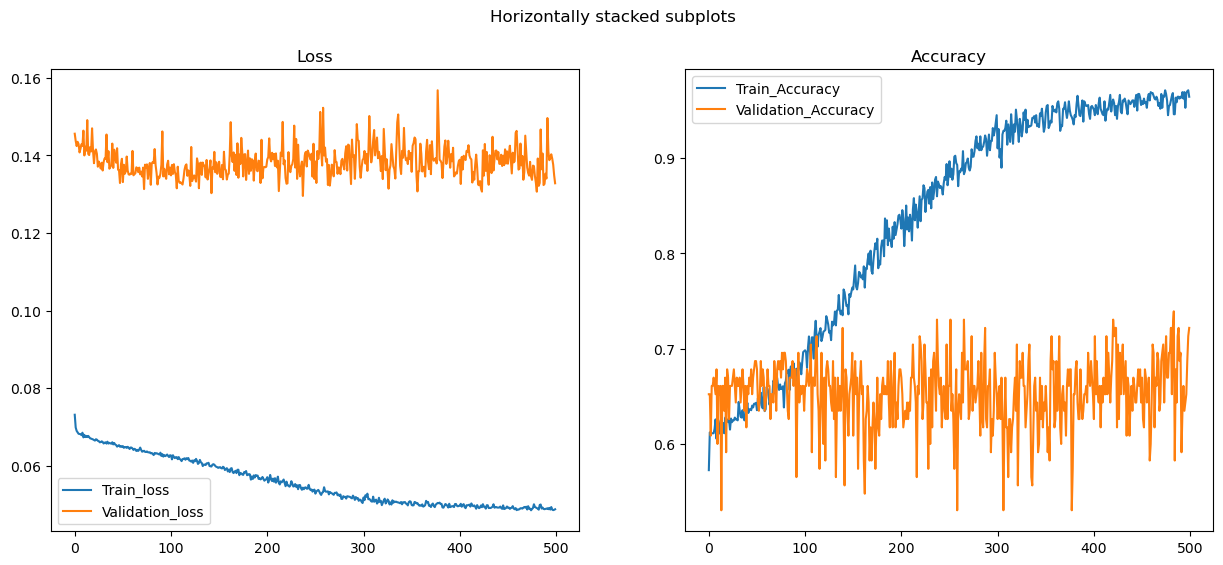

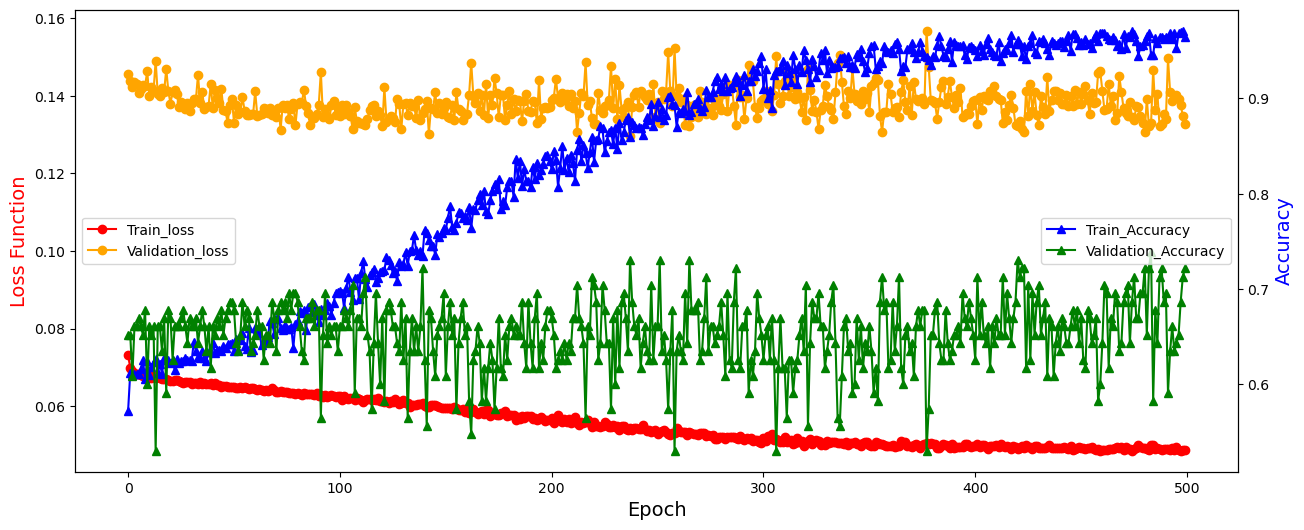

Current time: 162.510 minutes. Time expected till completion: 0.000 minutes
Finished training in: 162.510 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

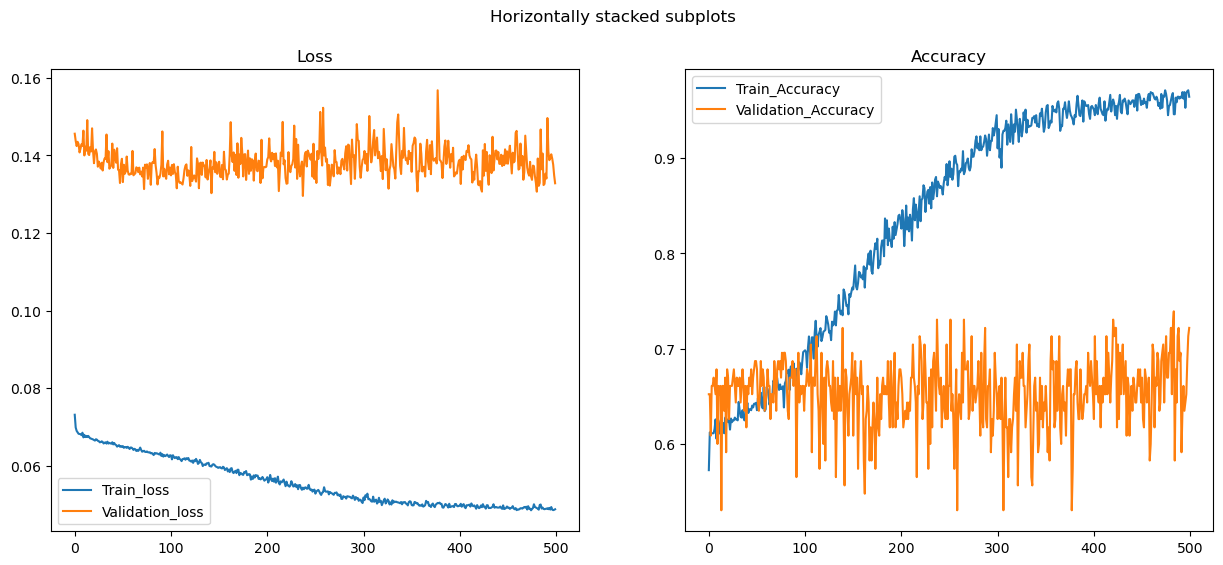

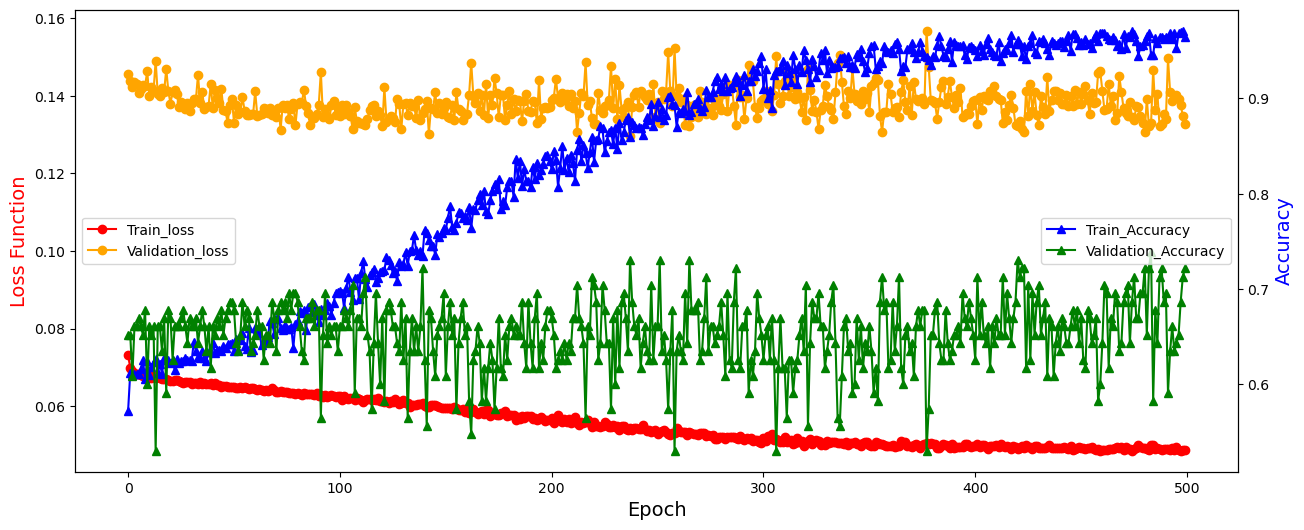

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 97.38878143133462%
Accuracy of the network on the 115 Validation instances: 72.17391304347827%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="10_10Conv_0Res_128FChannels_5Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points